# Taxi demand prediction in New York City


#### Objectives:
*  Task 1: Incorporate Fourier features as features into Regression models and measure MAPE. <br>
* Task 2: Perform hyper-parameter tuning for Regression models.
        2a. Linear Regression: Grid Search
        2b. Random Forest: Random Search 
        2c. Xgboost: Random Search
* Task 3: Explore more time-series features using Google search/Quora/Stackoverflow
to reduce the MAPE to < 12%

##### Procedure for accomplished above objectives is as :

##### Task 1:
As the datsets is in time series ,convert into frequecy domain to get frequecy and amplitude values using fourier transform.And these Frequecy and amplitude of region_cum feature can be used as features.These features are important becuase of repeating structure of datasets.

* 1.Find the frequecy according to maximum amplitude

* 2.sort the frequecy to get important frequecy and corresponding amplitude.This is our new feature.

* 3.Concatenate newfeature  with  datasets .(this datsets is used for training and testing the model to get Train MAPE & Test MAPE)

##### Task2:

Perform hyper-parameter tuning for Regression models.
  * 2a. Linear Regression: Grid Search
  * 2b. Random Forest: Random Search 
  * 2c. Xgboost: Random Search
  


##### Task 3:
 
 * Use time series feature in task1
 * Split the Train & test dataset into 75-25%
 * Use cluster size=30
 * here, I used LSTM model and MAPE <12% (It is new model )





Refrence applied ai

#####  Haversine distance
It calculates the great circle distance between two points on a sphere given their longitude and latitude[https://en.wikipedia.org/wiki/Haversine_formula]


To use this distance   gpxpy.geo should be install in system.In google colab ,it can be directly fetch from gitclone as shown in below code. 

In [0]:
# Import Librabry
import dask.dataframe as dd
import pandas as pd
import folium # folium is used for street map
import datetime
import time
import numpy as np
import matplotlib
matplotlib.use('nbagg')# for making plot more interactive
# like zoom_in and zoom_out
from matplotlib import rcParams # size of plots
import matplotlib.pylab as plt
import seaborn as sns


In [0]:
# harversine distance
!pip install git+https://github.com/tkrajina/gpxpy
import gpxpy.geo 

  Cloning https://github.com/tkrajina/gpxpy to /tmp/pip-req-build-gekhxpgs
  Stored in directory: /tmp/pip-ephem-wheel-cache-evv2o0kv/wheels/7f/41/55/68dd152d9886f8571e59a62ef1be8412420c9e75804e3581e5
Successfully built gpxpy


In [0]:
from sklearn.cluster import MiniBatchKMeans,KMeans  # use for clustering  data
import math
import pickle
import os
import xgboost as xgb

# to install sklearn: pip install -U scikit-learn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

In [0]:
# download migwin: https://mingw-w64.org/doku.php/download/mingw-builds
# install it in your system and keep the path, migw_path ='installed path'
!mkdir data0 && wget https://mingw-w64.org/doku.php/download/mingw-builds-d data/
  
mingw_path = 'data0'
os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']
 

mkdir: cannot create directory ‘data0’: File exists


In [0]:
# to download the csv file into google colab
!mkdir data01 && wget https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2015-01.csv -d

mkdir: cannot create directory ‘data01’: File exists


In [0]:
# To read csv file using dask
month=dd.read_csv('yellow_tripdata_2015-01.csv')
print(month.columns)

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RateCodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount'],
      dtype='object')


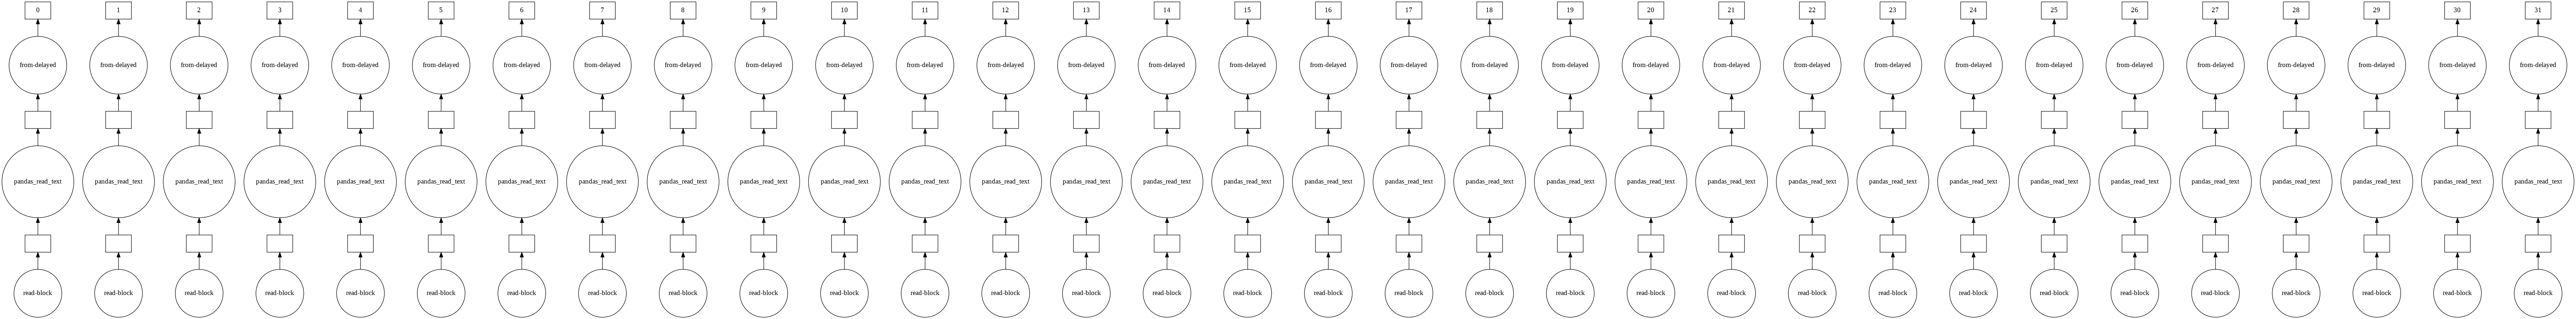

In [0]:
month.visualize()

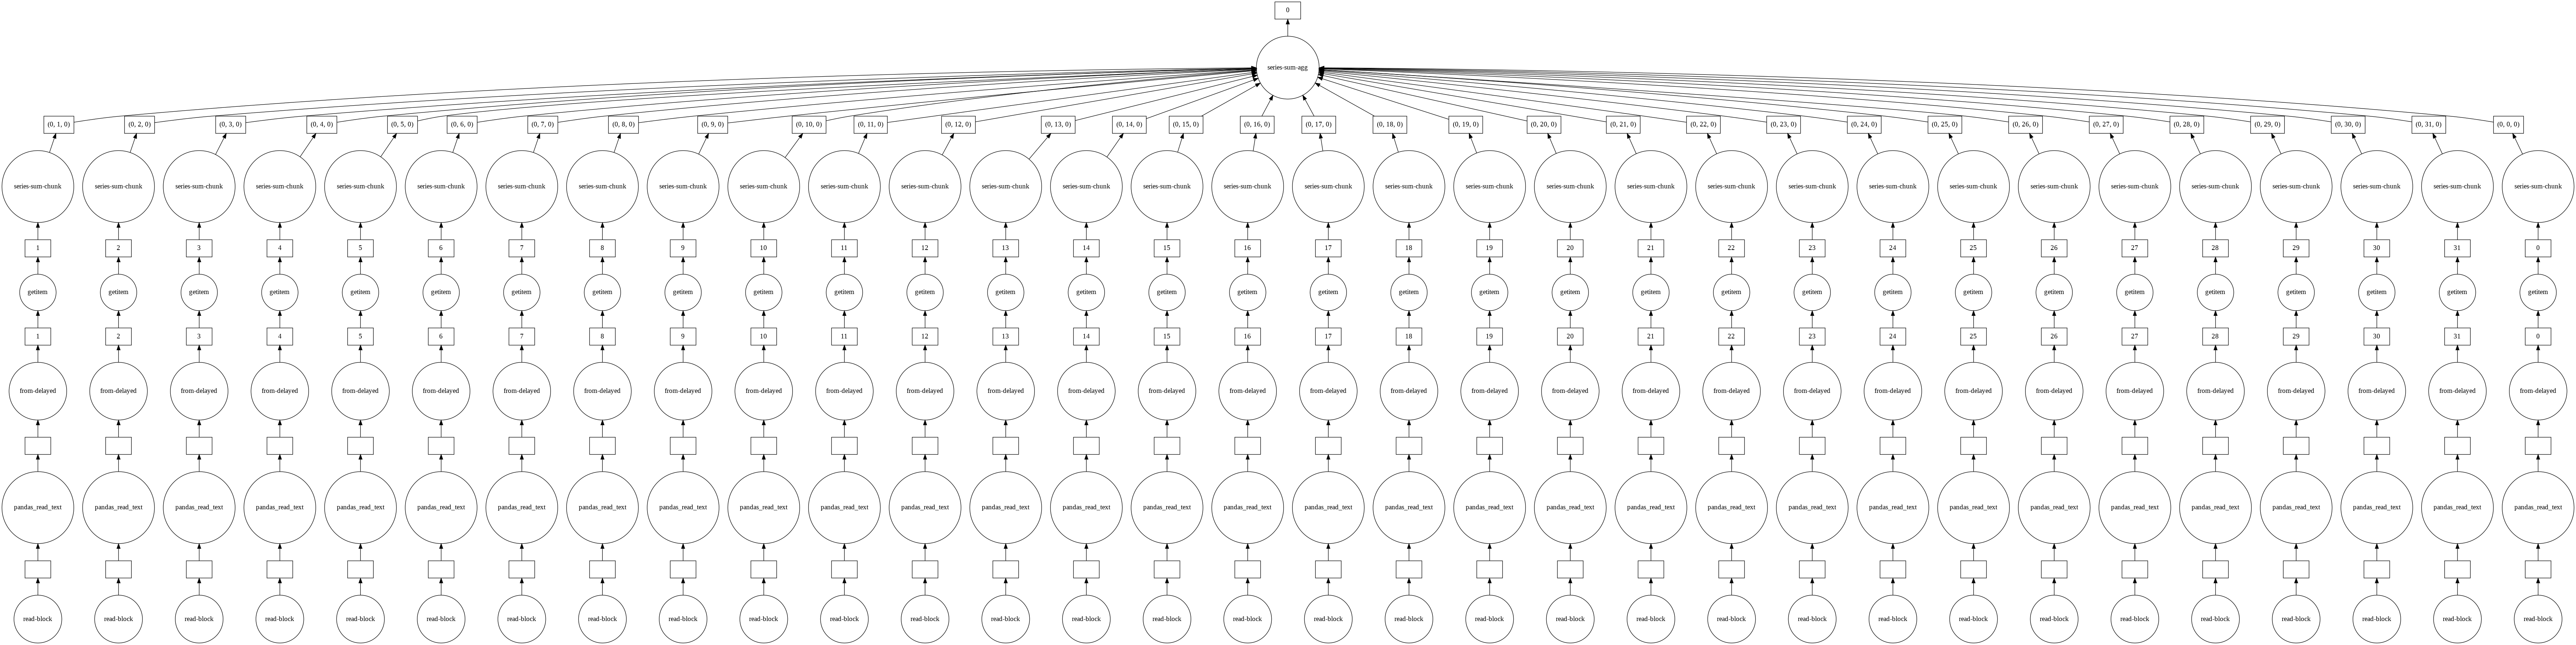

In [0]:
month.fare_amount.sum().visualize()


# ML Problem Formulation
 Time-series forecasting and Regression

To find number of pickups, given location cordinates(latitude and longitude) and time, in the query reigion and surrounding regions.

To solve the above we would be using data collected in Jan - Mar 2015 to predict the pickups in Jan - Mar 2016.


# Performance metrics
1. Mean Absolute percentage error.
2. Mean Squared error.

## Data Cleaning

In this section we will be doing univariate analysis and removing outlier/illegitimate values which may be caused due to some error

In [0]:
#table below shows few datapoints along with all our features
month.head(7)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,-73.993896,40.750111,1,N,-73.974785,40.750618,1,12.0,1.0,0.5,3.25,0.00,0.3,17.05
1,1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.30,-74.001648,40.724243,1,N,-73.994415,40.759109,1,14.5,0.5,0.5,2.00,0.00,0.3,17.80
2,1,2015-01-10 20:33:38,2015-01-10 20:43:41,1,1.80,-73.963341,40.802788,1,N,-73.951820,40.824413,2,9.5,0.5,0.5,0.00,0.00,0.3,10.80
3,1,2015-01-10 20:33:39,2015-01-10 20:35:31,1,0.50,-74.009087,40.713818,1,N,-74.004326,40.719986,2,3.5,0.5,0.5,0.00,0.00,0.3,4.80
4,1,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.00,-73.971176,40.762428,1,N,-74.004181,40.742653,2,15.0,0.5,0.5,0.00,0.00,0.3,16.30
5,1,2015-01-10 20:33:39,2015-01-10 20:53:52,1,9.00,-73.874374,40.774048,1,N,-73.986977,40.758194,1,27.0,0.5,0.5,6.70,5.33,0.3,40.33
6,1,2015-01-10 20:33:39,2015-01-10 20:58:31,1,2.20,-73.983276,40.726009,1,N,-73.992470,40.749634,2,14.0,0.5,0.5,0.00,0.00,0.3,15.30


In [0]:
month.tail(5)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
12615,1,2015-01-10 19:01:44,2015-01-10 19:05:40,2,1.0,-73.951988,40.786217,1,N,-73.953735,40.775162,1,5.5,0.0,0.5,1.25,0.0,0.3,7.55
12616,1,2015-01-10 19:01:44,2015-01-10 19:07:26,2,0.8,-73.982742,40.728184,1,N,-73.974976,40.720013,1,6.0,0.0,0.5,2.00,0.0,0.3,8.80
12617,1,2015-01-10 19:01:44,2015-01-10 19:15:01,1,3.4,-73.979324,40.749550,1,N,-73.969101,40.787800,2,13.5,0.0,0.5,0.00,0.0,0.3,14.30
12618,1,2015-01-10 19:01:44,2015-01-10 19:17:03,1,1.3,-73.999565,40.738483,1,N,-73.981819,40.737652,1,10.5,0.0,0.5,2.25,0.0,0.3,13.55
12619,1,2015-01-10 19:01:45,2015-01-10 19:07:33,1,0.7,-73.960350,40.766399,1,N,-73.968643,40.760777,2,5.5,0.0,0.5,0.00,0.0,0.3,6.30


### 1. Pickup Latitude and Pickup Longitude

It is inferred from the source https://www.flickr.com/places/info/2459115 that New York is bounded by the location cordinates(lat,long) - (40.5774, -74.15) & (40.9176,-73.7004) so hence any cordinates not within these cordinates are not considered by us as we are only concerned with pickups which originate within New York.

In [0]:
# Plotting pickup coordinates which are outside the bounding box of NYC
# All the points outside the NYC
outlier_locations=month[((month.pickup_longitude <= -74.15)|(month.pickup_latitude <= 40.5774)|
                        (month.pickup_longitude >= -73.7004)| (month.pickup_latitude >= 40.9176))]
# Map with base location
map_osm = folium.Map(location=[40.734695,-73.990372],tiles='Stamen Toner')
# To plot 100 outliers on map
sample_locations=outlier_locations.head(10000)
#print(sample_locations.tail(3))
for i,j in sample_locations.iterrows():
  if int(j['pickup_latitude']) !=0:
    folium.Marker(list((j['pickup_latitude'],j['pickup_longitude']))).add_to(map_osm)
    

map_osm 
  

Observation:- 
As you can see above that there are some points just outside the boundary but there are a few that are in either South america, Mexico or Canada

### 2. Dropoff Latitude & Dropoff Longitude

It is inferred from the source https://www.flickr.com/places/info/2459115 that New York is bounded by the location coordinates(lat,long) - (40.5774, -74.15) & (40.9176,-73.7004) so hence any cordinates not within these cordinates are not considered by us as we are only concerned with dropoffs which are within New York.

In [0]:
# Plotting dropoff cordinates which are outside the bounding box of New-York 
# we will collect all the points outside the bounding box of newyork city to outlier_locations
outlier_locations = month[((month.dropoff_longitude <= -74.15) | (month.dropoff_latitude <= 40.5774)| \
                   (month.dropoff_longitude >= -73.7004) | (month.dropoff_latitude >= 40.9176))]

# creating a map with the a base location
# read more about the folium here: http://folium.readthedocs.io/en/latest/quickstart.html

# note: you dont need to remember any of these, you dont need indeepth knowledge on these maps and plots

map_osm = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Toner')

# we will spot only first 100 outliers on the map, plotting all the outliers will take more time
sample_locations = outlier_locations.head(10000)
for i,j in sample_locations.iterrows():
    if int(j['pickup_latitude']) != 0:
        folium.Marker(list((j['dropoff_latitude'],j['dropoff_longitude']))).add_to(map_osm)
map_osm

Observation:-
  The observations here are similar to those obtained while analysing pickup latitude and longitude

### 3. Trip Durations:

According to NYC Taxi &amp; Limousine Commision Regulations the maximum allowed trip duration in a 24 hour interval is 12 hours.

In [0]:
# Timestamp are converted to unix so as to get trip_time & speed
# https://stackoverflow.com/a/27914405
def convert_to_unix(s):
  return time.mktime(datetime.datetime.strptime(s,
                                                "%Y-%m-%d %H:%M:%S").timetuple())
def return_with_trip_times(month):
    duration = month[['tpep_pickup_datetime','tpep_dropoff_datetime']].compute()
    #pickups and dropoffs to unix time
    duration_pickup = [convert_to_unix(x) for x in duration['tpep_pickup_datetime'].values]
    duration_drop = [convert_to_unix(x) for x in duration['tpep_dropoff_datetime'].values]
    #calculate duration of trips
    durations = (np.array(duration_drop) - np.array(duration_pickup))/float(60)

    #append durations of trips and speed in miles/hr to a new dataframe
    new_frame = month[['passenger_count','trip_distance',
                       'pickup_longitude','pickup_latitude',
                       'dropoff_longitude','dropoff_latitude',
                       'total_amount']].compute()
    
    new_frame['trip_times'] = durations
    new_frame['pickup_times'] = duration_pickup
    new_frame['Speed'] = 60*(new_frame['trip_distance']/new_frame['trip_times'])
    
    return new_frame


In [0]:
frame_with_durations = return_with_trip_times(month)

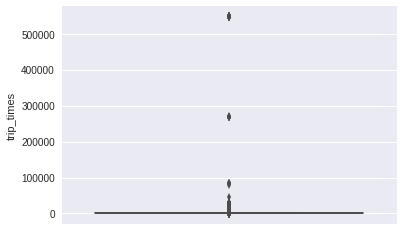

In [0]:
# the skewed box plot shows us the presence of outliers 
%matplotlib inline

sns.boxplot(y="trip_times", data =frame_with_durations)
plt.show();

In [0]:
#calculating 0-100th percentile to find a the correct percentile value for removal of outliers
for i in range(0,100,10):
    var =frame_with_durations["trip_times"].values
    var = np.sort(var ,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

0 percentile value is -1211.0166666666667
10 percentile value is 3.8333333333333335
20 percentile value is 5.383333333333334
30 percentile value is 6.816666666666666
40 percentile value is 8.3
50 percentile value is 9.95
60 percentile value is 11.866666666666667
70 percentile value is 14.283333333333333
80 percentile value is 17.633333333333333
90 percentile value is 23.45
100 percentile value is  548555.6333333333


In [0]:
#looking further from the 99th percecntile
for i in range(90,100):
    var =frame_with_durations["trip_times"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

90 percentile value is 23.45
91 percentile value is 24.35
92 percentile value is 25.383333333333333
93 percentile value is 26.55
94 percentile value is 27.933333333333334
95 percentile value is 29.583333333333332
96 percentile value is 31.683333333333334
97 percentile value is 34.46666666666667
98 percentile value is 38.71666666666667
99 percentile value is 46.75
100 percentile value is  548555.6333333333


In [0]:
#removing data based on our analysis and TLC regulations
frame_with_durations_modified=frame_with_durations[(frame_with_durations.trip_times>1) & (frame_with_durations.trip_times<720)]

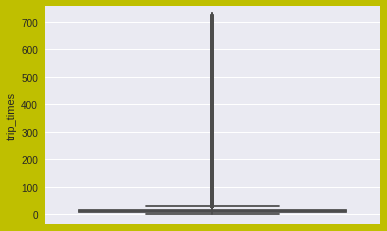

In [0]:
#box-plot after removal of outliers
fig3 = plt.figure( facecolor='y', edgecolor='k')
sns.boxplot(y="trip_times", data =frame_with_durations_modified)
plt.show()

<Figure size 432x288 with 0 Axes>

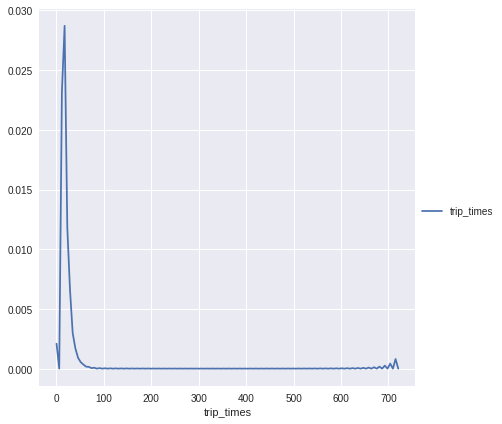

In [0]:
#pdf of trip-times after removing the outliers
fig3 = plt.figure( facecolor='y', edgecolor='k')
sns.FacetGrid(frame_with_durations_modified,size=6) \
      .map(sns.kdeplot,"trip_times") \
      .add_legend()
plt.show()

In [0]:
#converting the values to log-values to chec for log-normal
import math
frame_with_durations_modified['log_times']=[math.log(i) for i in frame_with_durations_modified['trip_times'].values]

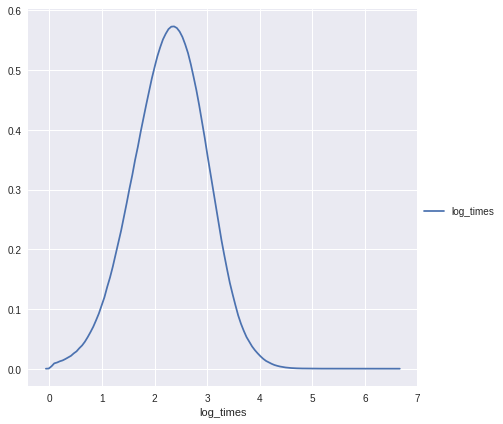

In [0]:
#pdf of log-values
sns.FacetGrid(frame_with_durations_modified,size=6) \
      .map(sns.kdeplot,"log_times") \
      .add_legend();
plt.show();

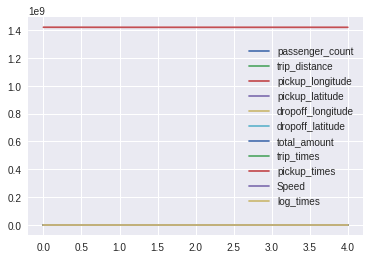

In [0]:
frame_with_durations_modified[:5].plot()
plt.show()

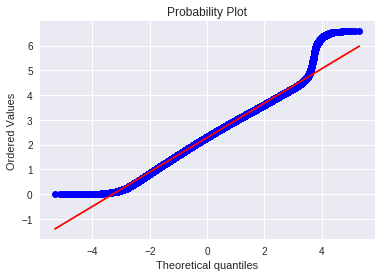

In [0]:
import scipy
#Q-Q plot for checking if trip-times is log-normal
scipy.stats.probplot(frame_with_durations_modified['log_times'].values, plot=plt)
plt.show()

### 4. Speed

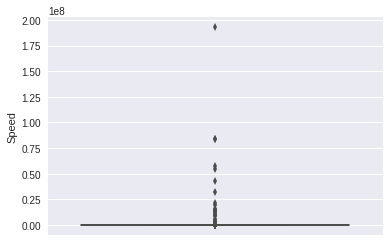

In [0]:
# check for any outliers in the data after trip duration outliers removed
# box-plot for speeds with outliers
frame_with_durations_modified['Speed'] = 60*(frame_with_durations_modified['trip_distance']/frame_with_durations_modified['trip_times'])
sns.boxplot(y="Speed", data =frame_with_durations_modified)
plt.show()

In [0]:
#calculating speed values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0,100,10):
    var =frame_with_durations_modified["Speed"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is 0.0
10 percentile value is 6.409495548961425
20 percentile value is 7.80952380952381
30 percentile value is 8.929133858267717
40 percentile value is 9.98019801980198
50 percentile value is 11.06865671641791
60 percentile value is 12.286689419795222
70 percentile value is 13.796407185628745
80 percentile value is 15.963224893917962
90 percentile value is 20.186915887850468
100 percentile value is  192857142.85714284


In [0]:
#calculating speed values at each percntile 90,91,92,93,94,95,96,97,98,99,100
for i in range(90,100):
    var =frame_with_durations_modified["Speed"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 20.186915887850468
91 percentile value is 20.91645569620253
92 percentile value is 21.752988047808763
93 percentile value is 22.721893491124263
94 percentile value is 23.844155844155843
95 percentile value is 25.182552504038775
96 percentile value is 26.80851063829787
97 percentile value is 28.84304932735426
98 percentile value is 31.591128254580514
99 percentile value is 35.7513566847558
100 percentile value is  192857142.85714284


In [0]:
#calculating speed values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var =frame_with_durations_modified["Speed"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 35.7513566847558
99.1 percentile value is 36.31084727468969
99.2 percentile value is 36.91470054446461
99.3 percentile value is 37.588235294117645
99.4 percentile value is 38.33035714285714
99.5 percentile value is 39.17580340264651
99.6 percentile value is 40.15384615384615
99.7 percentile value is 41.338301043219076
99.8 percentile value is 42.86631016042781
99.9 percentile value is 45.3107822410148
100 percentile value is  192857142.85714284


In [0]:
#removing further outliers based on the 99.9th percentile value
frame_with_durations_modified=frame_with_durations[(frame_with_durations.Speed>0) & (frame_with_durations.Speed<45.31)]

In [0]:
#avg.speed of cabs in New-York
sum(frame_with_durations_modified["Speed"]) / float(len(frame_with_durations_modified["Speed"]))

12.450173996027528

The avg speed in Newyork speed is 12.45miles/hr, so a cab driver can travel2 miles per 10min on avg.

### 4. Trip Distance

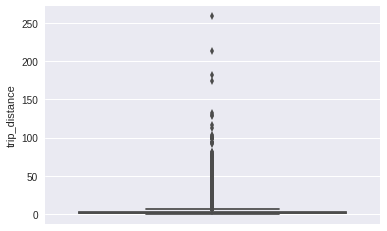

In [0]:
# up to now we have removed the outliers based on trip durations and cab speeds
# lets try if there are any outliers in trip distances
# box-plot showing outliers in trip-distance values
sns.boxplot(y="trip_distance", data =frame_with_durations_modified)
plt.show()

In [0]:
#calculating trip distance values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0,100,10):
    var =frame_with_durations_modified["trip_distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is 0.01
10 percentile value is 0.66
20 percentile value is 0.9
30 percentile value is 1.1
40 percentile value is 1.39
50 percentile value is 1.69
60 percentile value is 2.07
70 percentile value is 2.6
80 percentile value is 3.6
90 percentile value is 5.97
100 percentile value is  258.9


In [0]:
#calculating trip distance values at each percntile 90,91,92,93,94,95,96,97,98,99,100
for i in range(90,100):
    var =frame_with_durations_modified["trip_distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 5.97
91 percentile value is 6.45
92 percentile value is 7.07
93 percentile value is 7.85
94 percentile value is 8.72
95 percentile value is 9.6
96 percentile value is 10.6
97 percentile value is 12.1
98 percentile value is 16.03
99 percentile value is 18.17
100 percentile value is  258.9


In [0]:
#calculating trip distance values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var =frame_with_durations_modified["trip_distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 18.17
99.1 percentile value is 18.37
99.2 percentile value is 18.6
99.3 percentile value is 18.83
99.4 percentile value is 19.13
99.5 percentile value is 19.5
99.6 percentile value is 19.96
99.7 percentile value is 20.5
99.8 percentile value is 21.22
99.9 percentile value is 22.57
100 percentile value is  258.9


In [0]:
#removing further outliers based on the 99.9th percentile value
frame_with_durations_modified=frame_with_durations[(frame_with_durations.trip_distance>0) & (frame_with_durations.trip_distance<23)]

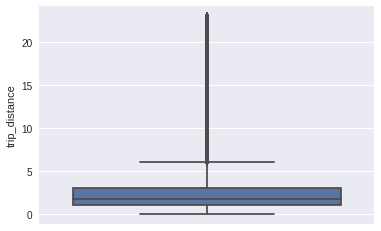

In [0]:
#box-plot after removal of outliers
sns.boxplot(y="trip_distance", data = frame_with_durations_modified)
plt.show()

### 5. Total Fare

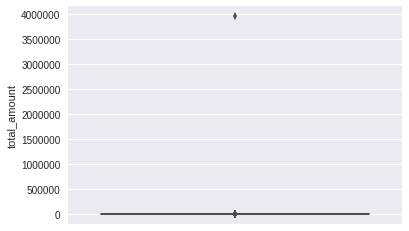

In [0]:
# up to now we have removed the outliers based on trip durations, cab speeds, and trip distances
# lets try if there are any outliers in based on the total_amount
# box-plot showing outliers in fare
sns.boxplot(y="total_amount", data =frame_with_durations_modified)
plt.show()

In [0]:
#calculating total fare amount values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0,100,10):
    var = frame_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is -242.55
10 percentile value is 6.3
20 percentile value is 7.8
30 percentile value is 8.8
40 percentile value is 9.8
50 percentile value is 11.16
60 percentile value is 12.8
70 percentile value is 14.8
80 percentile value is 18.3
90 percentile value is 25.8
100 percentile value is  3950611.6


In [0]:
#calculating total fare amount values at each percntile 90,91,92,93,94,95,96,97,98,99,100
for i in range(90,100):
    var = frame_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 25.8
91 percentile value is 27.3
92 percentile value is 29.3
93 percentile value is 31.8
94 percentile value is 34.8
95 percentile value is 38.53
96 percentile value is 42.6
97 percentile value is 48.13
98 percentile value is 58.13
99 percentile value is 66.13
100 percentile value is  3950611.6


In [0]:
#calculating total fare amount values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var = frame_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 66.13
99.1 percentile value is 68.13
99.2 percentile value is 69.6
99.3 percentile value is 69.6
99.4 percentile value is 69.73
99.5 percentile value is 69.75
99.6 percentile value is 69.76
99.7 percentile value is 72.58
99.8 percentile value is 75.35
99.9 percentile value is 88.28
100 percentile value is  3950611.6


Observation:- As even the 99.9th percentile value doesnt look like an outlier,as there is not much difference between the 99.8th percentile and 99.9th percentile, we move on to do graphical analyis

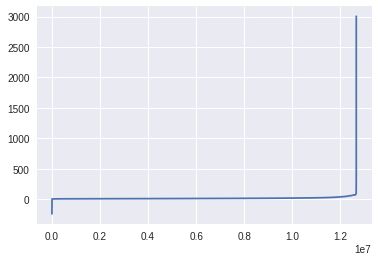

In [0]:
#below plot shows us the fare values(sorted) to find a sharp increase to remove those values as outliers
# plot the fare amount excluding last two values in sorted data
plt.plot(var[:-2])
plt.show()

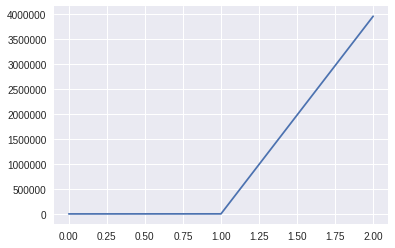

In [0]:
# a very sharp increase in fare values can be seen 
# plotting last three total fare values, and we can observe there is share increase in the values
plt.plot(var[-3:])
plt.show()

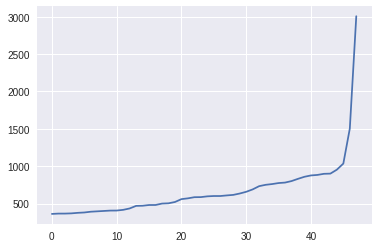

In [0]:
#now looking at values not including the last two points we again find a drastic increase at around 1000 fare value
# we plot last 50 values excluding last two values
plt.plot(var[-50:-2])
plt.show()

## Remove all outliers/erronous points.

In [0]:
#removing all outliers based on our univariate analysis above
def remove_outliers(new_frame):

    
    a = new_frame.shape[0]
    print ("Number of pickup records = ",a)
    temp_frame = new_frame[((new_frame.dropoff_longitude >= -74.15) & (new_frame.dropoff_longitude <= -73.7004) &\
                       (new_frame.dropoff_latitude >= 40.5774) & (new_frame.dropoff_latitude <= 40.9176)) & \
                       ((new_frame.pickup_longitude >= -74.15) & (new_frame.pickup_latitude >= 40.5774)& \
                       (new_frame.pickup_longitude <= -73.7004) & (new_frame.pickup_latitude <= 40.9176))]
    b = temp_frame.shape[0]
    print ("Number of outlier coordinates lying outside NY boundaries:",(a-b))

    
    temp_frame = new_frame[(new_frame.trip_times > 0) & (new_frame.trip_times < 720)]
    c = temp_frame.shape[0]
    print ("Number of outliers from trip times analysis:",(a-c))
    
    
    temp_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 23)]
    d = temp_frame.shape[0]
    print ("Number of outliers from trip distance analysis:",(a-d))
    
    temp_frame = new_frame[(new_frame.Speed <= 65) & (new_frame.Speed >= 0)]
    e = temp_frame.shape[0]
    print ("Number of outliers from speed analysis:",(a-e))
    
    temp_frame = new_frame[(new_frame.total_amount <1000) & (new_frame.total_amount >0)]
    f = temp_frame.shape[0]
    print ("Number of outliers from fare analysis:",(a-f))
    
    
    new_frame = new_frame[((new_frame.dropoff_longitude >= -74.15) & (new_frame.dropoff_longitude <= -73.7004) &\
                       (new_frame.dropoff_latitude >= 40.5774) & (new_frame.dropoff_latitude <= 40.9176)) & \
                       ((new_frame.pickup_longitude >= -74.15) & (new_frame.pickup_latitude >= 40.5774)& \
                       (new_frame.pickup_longitude <= -73.7004) & (new_frame.pickup_latitude <= 40.9176))]
    
    new_frame = new_frame[(new_frame.trip_times > 0) & (new_frame.trip_times < 720)]
    new_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 23)]
    new_frame = new_frame[(new_frame.Speed < 45.31) & (new_frame.Speed > 0)]
    new_frame = new_frame[(new_frame.total_amount <1000) & (new_frame.total_amount >0)]
    
    print ("Total outliers removed",a - new_frame.shape[0])
    print ("---")
    return new_frame

In [0]:
print ("Removing outliers in the month of Jan-2015")
print ("----")
frame_with_durations_outliers_removed = remove_outliers(frame_with_durations)
print("fraction of data points that remain after removing outliers", 
      float(len(frame_with_durations_outliers_removed))/len(frame_with_durations))

Removing outliers in the month of Jan-2015
----
Number of pickup records =  12748986
Number of outlier coordinates lying outside NY boundaries: 293919
Number of outliers from trip times analysis: 23889
Number of outliers from trip distance analysis: 92597
Number of outliers from speed analysis: 24473
Number of outliers from fare analysis: 5275
Total outliers removed 377910
---
fraction of data points that remain after removing outliers 0.9703576425607495


# Data-preperation
## Clustering/Segmentation

In [0]:
#trying different cluster sizes to choose the right K in K-means
coords = frame_with_durations_outliers_removed[['pickup_latitude', 
                                                'pickup_longitude']].values
neighbours=[]

def find_min_distance(cluster_centers, cluster_len):
    nice_points = 0
    wrong_points = 0
    less2 = []
    more2 = []
    min_dist=1000
    for i in range(0, cluster_len):
        nice_points = 0
        wrong_points = 0
        for j in range(0, cluster_len):
            if j!=i:
                distance = gpxpy.geo.haversine_distance(cluster_centers[i][0],
                                                        cluster_centers[i][1],
                                                        cluster_centers[j][0],
                                                        cluster_centers[j][1])
                min_dist = min(min_dist,distance/(1.60934*1000))
                if (distance/(1.60934*1000)) <= 2:
                    nice_points +=1
                else:
                    wrong_points += 1
        less2.append(nice_points)
        more2.append(wrong_points)
    neighbours.append(less2)
    print ("On choosing a cluster size of ",cluster_len,"\nAvg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2):", np.ceil(sum(less2)/len(less2)), "\nAvg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2):", np.ceil(sum(more2)/len(more2)),"\nMin inter-cluster distance = ",min_dist,"\n---")

def find_clusters(increment):
    kmeans = MiniBatchKMeans(n_clusters=increment, batch_size=10000,random_state=42).fit(coords)
    frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])
    cluster_centers = kmeans.cluster_centers_
    cluster_len = len(cluster_centers)
    return cluster_centers, cluster_len

# we need to choose number of clusters so that, there are more number of cluster regions 
#that are close to any cluster center
# and make sure that the minimum inter cluster should not be very less
for increment in range(10, 100, 10):
    cluster_centers, cluster_len = find_clusters(increment)
    find_min_distance(cluster_centers, cluster_len)            

On choosing a cluster size of  10 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 2.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 8.0 
Min inter-cluster distance =  1.0945442325142543 
---
On choosing a cluster size of  20 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 4.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 16.0 
Min inter-cluster distance =  0.7131298007387813 
---
On choosing a cluster size of  30 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 8.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 22.0 
Min inter-cluster distance =  0.5185088176172206 
---
On choosing a cluster size of  40 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 8.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 32.0 
Min inter-cluster distance 

## Cluster size=30

### Inference:
- The main objective was to find a optimal min. distance(Which roughly estimates to the radius of a cluster) between the clusters which we got was 30

In [0]:
# if check for the 50 clusters you can observe that there are two clusters with only 0.3 miles apart from each other
# so we choose 30 clusters for solve the further problem

# Getting 30 clusters using the kmeans 
kmeans = MiniBatchKMeans(n_clusters=30, batch_size=10000,random_state=0).fit(coords)
frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])

### Plotting the cluster centers:

In [0]:
# Plotting the cluster centers on OSM
cluster_centers = kmeans.cluster_centers_
cluster_len = len(cluster_centers)
map_osm = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Toner')
for i in range(cluster_len):
    folium.Marker(list((cluster_centers[i][0],cluster_centers[i][1])), popup=(str(cluster_centers[i][0])+str(cluster_centers[i][1]))).add_to(map_osm)
map_osm

### Plotting the clusters:

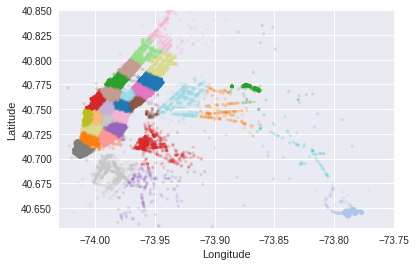

In [0]:
#Visualising the clusters on a map
def plot_clusters(frame):
    city_long_border = (-74.03, -73.75)
    city_lat_border = (40.63, 40.85)
    fig, ax = plt.subplots(ncols=1, nrows=1)
    ax.scatter(frame.pickup_longitude.values[:100000], frame.pickup_latitude.values[:100000], s=10, lw=0,
               c=frame.pickup_cluster.values[:100000], cmap='tab20', alpha=0.2)
    ax.set_xlim(city_long_border)
    ax.set_ylim(city_lat_border)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.show()

plot_clusters(frame_with_durations_outliers_removed)

## Time-binning

In [0]:
#Refer:https://www.unixtimestamp.com/
# 1420070400 : 2015-01-01 00:00:00 
# 1422748800 : 2015-02-01 00:00:00 
# 1425168000 : 2015-03-01 00:00:00
# 1427846400 : 2015-04-01 00:00:00 
# 1430438400 : 2015-05-01 00:00:00 
# 1433116800 : 2015-06-01 00:00:00

# 1451606400 : 2016-01-01 00:00:00 
# 1454284800 : 2016-02-01 00:00:00 
# 1456790400 : 2016-03-01 00:00:00
# 1459468800 : 2016-04-01 00:00:00 
# 1462060800 : 2016-05-01 00:00:00 
# 1464739200 : 2016-06-01 00:00:00

def add_pickup_bins(frame,month,year):
    unix_pickup_times=[i for i in frame['pickup_times'].values]
    unix_times = [[1420070400,1422748800,1425168000,1427846400,1430438400,1433116800],\
                    [1451606400,1454284800,1456790400,1459468800,1462060800,1464739200]]
    
    start_pickup_unix=unix_times[year-2015][month-1]
    # https://www.timeanddate.com/time/zones/est
    # (int((i-start_pickup_unix)/600)+33) : our unix time is in gmt to we are converting it to est
    tenminutewise_binned_unix_pickup_times=[(int((i-start_pickup_unix)/600)+33) for i in unix_pickup_times]
    frame['pickup_bins'] = np.array(tenminutewise_binned_unix_pickup_times)
    return frame

In [0]:
# clustering, making pickup bins and grouping by pickup cluster and pickup bins
frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])
jan_2015_frame = add_pickup_bins(frame_with_durations_outliers_removed,1,2015)
jan_2015_groupby = jan_2015_frame[['pickup_cluster','pickup_bins','trip_distance']].groupby(['pickup_cluster','pickup_bins']).count()

In [0]:
# we add two more columns 'pickup_cluster'(to which cluster it belogns to) 
# and 'pickup_bins' (to which 10min intravel the trip belongs to)
jan_2015_frame.head()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,trip_times,pickup_times,Speed,pickup_cluster,pickup_bins
0,1,1.59,-73.993896,40.750111,-73.974785,40.750618,17.05,18.050000,1.421349e+09,5.285319,14,2163
1,1,3.30,-74.001648,40.724243,-73.994415,40.759109,17.80,19.833333,1.420922e+09,9.983193,25,1452
2,1,1.80,-73.963341,40.802788,-73.951820,40.824413,10.80,10.050000,1.420922e+09,10.746269,8,1452
3,1,0.50,-74.009087,40.713818,-74.004326,40.719986,4.80,1.866667,1.420922e+09,16.071429,21,1452
4,1,3.00,-73.971176,40.762428,-74.004181,40.742653,16.30,19.316667,1.420922e+09,9.318378,28,1452


In [0]:
# hear the trip_distance represents the number of pickups that are happend in that particular 10min intravel
# this data frame has two indices
# primary index: pickup_cluster (cluster number)
# secondary index : pickup_bins (we devid whole months time into 10min intravels 24*31*60/10 =4464bins)
jan_2015_groupby.head()

trip_distance
pickup_cluster pickup_bins               
0              33                     138
               34                     262
               35                     311
               36                     325
               37                     381

To download the datsets directly from web into google colab, following directory are created and csv file is downloaded into it.

In [0]:
!mkdir data211 && wget https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2016-01.csv -d

DEBUG output created by Wget 1.19.4 on linux-gnu.

Reading HSTS entries from /root/.wget-hsts
URI encoding = ‘UTF-8’
Converted file name 'yellow_tripdata_2016-01.csv' (UTF-8) -> 'yellow_tripdata_2016-01.csv' (UTF-8)
--2019-03-17 06:15:28--  https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2016-01.csv
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.130.253
Caching s3.amazonaws.com => 52.216.130.253
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.130.253|:443... connected.
Created socket 3.
Releasing 0x00005555b847e980 (new refcount 1).
Initiating SSL handshake.
Handshake successful; connected socket 3 to SSL handle 0x00005555b8440000
certificate:
  subject: CN=s3.amazonaws.com,O=Amazon.com Inc.,L=Seattle,ST=Washington,C=US
  issuer:  CN=DigiCert Baltimore CA-2 G2,OU=www.digicert.com,O=DigiCert Inc,C=US
X509 certificate successfully verified and matches host s3.amazonaws.com

---request begin---
GET /nyc-tlc/trip+data/yellow_tripdata_2016-01.csv HTTP/1.1
User-A

In [0]:
!mkdir data311 && wget https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2016-02.csv -d

DEBUG output created by Wget 1.19.4 on linux-gnu.

Reading HSTS entries from /root/.wget-hsts
URI encoding = ‘UTF-8’
Converted file name 'yellow_tripdata_2016-02.csv' (UTF-8) -> 'yellow_tripdata_2016-02.csv' (UTF-8)
--2019-03-17 06:16:10--  https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2016-02.csv
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.238.245
Caching s3.amazonaws.com => 52.216.238.245
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.238.245|:443... connected.
Created socket 3.
Releasing 0x000055cf0231a980 (new refcount 1).
Initiating SSL handshake.
Handshake successful; connected socket 3 to SSL handle 0x000055cf022dc000
certificate:
  subject: CN=s3.amazonaws.com,O=Amazon.com Inc.,L=Seattle,ST=Washington,C=US
  issuer:  CN=DigiCert Baltimore CA-2 G2,OU=www.digicert.com,O=DigiCert Inc,C=US
X509 certificate successfully verified and matches host s3.amazonaws.com

---request begin---
GET /nyc-tlc/trip+data/yellow_tripdata_2016-02.csv HTTP/1.1
User-A

In [0]:
!mkdir data411 && wget https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2016-03.csv -d

DEBUG output created by Wget 1.19.4 on linux-gnu.

Reading HSTS entries from /root/.wget-hsts
URI encoding = ‘UTF-8’
Converted file name 'yellow_tripdata_2016-03.csv' (UTF-8) -> 'yellow_tripdata_2016-03.csv' (UTF-8)
--2019-03-17 06:16:50--  https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2016-03.csv
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.227.171
Caching s3.amazonaws.com => 52.216.227.171
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.227.171|:443... connected.
Created socket 3.
Releasing 0x0000558d8944e980 (new refcount 1).
Initiating SSL handshake.
Handshake successful; connected socket 3 to SSL handle 0x0000558d89410000
certificate:
  subject: CN=s3.amazonaws.com,O=Amazon.com Inc.,L=Seattle,ST=Washington,C=US
  issuer:  CN=DigiCert Baltimore CA-2 G2,OU=www.digicert.com,O=DigiCert Inc,C=US
X509 certificate successfully verified and matches host s3.amazonaws.com

---request begin---
GET /nyc-tlc/trip+data/yellow_tripdata_2016-03.csv HTTP/1.1
User-A

In [0]:
# upto now we cleaned data and prepared data for the month 2015,


# Data Preparation for the months of Jan,Feb and March 2016
def datapreparation(month,kmeans,month_no,year_no):
    
    print ("Return with trip times..")

    frame_with_durations = return_with_trip_times(month)
    
    print ("Remove outliers..")
    frame_with_durations_outliers_removed = remove_outliers(frame_with_durations)
    
    print ("Estimating clusters..")
    frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])
    #frame_with_durations_outliers_removed_2016['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed_2016[['pickup_latitude', 'pickup_longitude']])

    print ("Final groupbying..")
    final_updated_frame = add_pickup_bins(frame_with_durations_outliers_removed,month_no,year_no)
    final_groupby_frame = final_updated_frame[['pickup_cluster','pickup_bins','trip_distance']].groupby(['pickup_cluster','pickup_bins']).count()
    
    return final_updated_frame,final_groupby_frame
    
month_jan_2016 = dd.read_csv('yellow_tripdata_2016-01.csv')
month_feb_2016 = dd.read_csv('yellow_tripdata_2016-02.csv')
month_mar_2016 = dd.read_csv('yellow_tripdata_2016-03.csv')

jan_2016_frame,jan_2016_groupby = datapreparation(month_jan_2016,kmeans,1,2016)
feb_2016_frame,feb_2016_groupby = datapreparation(month_feb_2016,kmeans,2,2016)
mar_2016_frame,mar_2016_groupby = datapreparation(month_mar_2016,kmeans,3,2016)

Return with trip times..
Remove outliers..
Number of pickup records =  10906858
Number of outlier coordinates lying outside NY boundaries: 214677
Number of outliers from trip times analysis: 27190
Number of outliers from trip distance analysis: 79742
Number of outliers from speed analysis: 21047
Number of outliers from fare analysis: 4991
Total outliers removed 297784
---
Estimating clusters..
Final groupbying..
Return with trip times..
Remove outliers..
Number of pickup records =  11382049
Number of outlier coordinates lying outside NY boundaries: 223161
Number of outliers from trip times analysis: 27670
Number of outliers from trip distance analysis: 81902
Number of outliers from speed analysis: 22437
Number of outliers from fare analysis: 5476
Total outliers removed 308177
---
Estimating clusters..
Final groupbying..
Return with trip times..
Remove outliers..
Number of pickup records =  12210952
Number of outlier coordinates lying outside NY boundaries: 232444
Number of outliers fro

## Smoothing

In [0]:
# Gets the unique bins where pickup values are present for each each reigion

# for each cluster region we will collect all the indices of 10min intravels in which the pickups are happened
# we got an observation that there are some pickpbins that doesnt have any pickups
def return_unq_pickup_bins(frame):
    values = []
    for i in range(0,30):
        new = frame[frame['pickup_cluster'] == i]
        list_unq = list(set(new['pickup_bins']))
        list_unq.sort()
        values.append(list_unq)
    return values

In [0]:
# for every month we get all indices of 10min intravels in which atleast one pickup got happened

#jan
jan_2015_unique = return_unq_pickup_bins(jan_2015_frame)
jan_2016_unique = return_unq_pickup_bins(jan_2016_frame)

#feb
feb_2016_unique = return_unq_pickup_bins(feb_2016_frame)

#march
mar_2016_unique = return_unq_pickup_bins(mar_2016_frame)

In [0]:
# for each cluster number of 10min intravels with 0 pickups
for i in range(30):
    print("for the ",i,"th cluster number of 10min intavels with zero pickups: ",4464 - len(set(jan_2015_unique[i])))
    print('-'*60)

for the  0 th cluster number of 10min intavels with zero pickups:  25
------------------------------------------------------------
for the  1 th cluster number of 10min intavels with zero pickups:  29
------------------------------------------------------------
for the  2 th cluster number of 10min intavels with zero pickups:  149
------------------------------------------------------------
for the  3 th cluster number of 10min intavels with zero pickups:  34
------------------------------------------------------------
for the  4 th cluster number of 10min intavels with zero pickups:  169
------------------------------------------------------------
for the  5 th cluster number of 10min intavels with zero pickups:  39
------------------------------------------------------------
for the  6 th cluster number of 10min intavels with zero pickups:  319
------------------------------------------------------------
for the  7 th cluster number of 10min intavels with zero pickups:  34
----------

there are two ways to fill up these values

Fill the missing value with 0's
 Fill the missing values with the avg values

 Case 1:(values missing at the start)  Ex1: \_ \_ \_ x =>ceil(x/4), ceil(x/4), ceil(x/4), ceil(x/4) Ex2: \_ \_ x => ceil(x/3), ceil(x/3), ceil(x/3) 
 Case 2:(values missing in middle)Ex1: x \_ \_ y => ceil((x+y)/4), ceil((x+y)/4), ceil((x+y)/4), ceil((x+y)/4)  Ex2: x \_ \_ \_ y => ceil((x+y)/5), ceil((x+y)/5), ceil((x+y)/5), ceil((x+y)/5), ceil((x+y)/5) 
 Case 3:(values missing at the end) Ex1: x \_ \_ \_  => ceil(x/4), ceil(x/4), ceil(x/4), ceil(x/4)  x \_  => ceil(x/2), ceil(x/2) 


In [0]:
# Fills a value of zero for every bin where no pickup data is present 
# the count_values: number pickps that are happened in each region for each 10min intravel
# ther icksups.
# values: number of unique bins

# for every 10min intravel(pickup_bin) we will check it is there in our unique bin,
# if it is there we will add the count_values[index] to smoothed data
# if not we add 0 to the smoothed data
# we finally return smoothed data
def fill_missing(count_values,values):
    smoothed_regions=[]
    ind=0
    for r in range(0,30):
        smoothed_bins=[]
        for i in range(4464):
            if i in values[r]:
                smoothed_bins.append(count_values[ind])
                ind+=1
            else:
                smoothed_bins.append(0)
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions

In [0]:
# Fills a value of zero for every bin where no pickup data is present 
# the count_values: number pickps that are happened in each region for each 10min intravel
# there wont be any value if there are no picksups.
# values: number of unique bins

# for every 10min intravel(pickup_bin) we will check it is there in our unique bin,
# if it is there we will add the count_values[index] to smoothed data
# if not we add smoothed data (which is calculated based on the methods that are discussed in the above markdown cell)
# we finally return smoothed data
def smoothing(count_values,values):
    smoothed_regions=[] # stores list of final smoothed values of each reigion
    ind=0
    repeat=0 
    smoothed_value=0
    for r in range(0,30):
        smoothed_bins=[] #stores the final smoothed values
        repeat=0
        for i in range(4464):
            if repeat!=0: # prevents iteration for a value which is already visited/resolved
                repeat-=1
                continue
            if i in values[r]: #checks if the pickup-bin exists 
                smoothed_bins.append(count_values[ind]) # appends the value of the pickup bin if it exists
            else:
                if i!=0:
                    right_hand_limit=0
                    for j in range(i,4464):
                        if  j not in values[r]: #searches for the left-limit or the pickup-bin value which has a pickup value
                            continue
                        else:
                            right_hand_limit=j
                            break
                    if right_hand_limit==0:
                    #Case 1: When we have the last/last few values are found to be missing,hence we have no right-limit here
                        smoothed_value=count_values[ind-1]*1.0/((4463-i)+2)*1.0                               
                        for j in range(i,4464):                              
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat=(4463-i)
                        ind-=1
                    else:
                    #Case 2: When we have the missing values between two known values
                        smoothed_value=(count_values[ind-1]+count_values[ind])*1.0/((right_hand_limit-i)+2)*1.0             
                        for j in range(i,right_hand_limit+1):
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat=(right_hand_limit-i)
                else:
                    #Case 3: When we have the first/first few values are found to be missing,hence we have no left-limit here
                    right_hand_limit=0
                    for j in range(i,4464):
                        if  j not in values[r]:
                            continue
                        else:
                            right_hand_limit=j
                            break
                    smoothed_value=count_values[ind]*1.0/((right_hand_limit-i)+1)*1.0
                    for j in range(i,right_hand_limit+1):
                            smoothed_bins.append(math.ceil(smoothed_value))
                    repeat=(right_hand_limit-i)
            ind+=1
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions


In [0]:
#Filling Missing values of Jan-2015 with 0
# here in jan_2015_groupby dataframe the trip_distance represents the number of pickups that are happened
jan_2015_fill = fill_missing(jan_2015_groupby['trip_distance'].values,jan_2015_unique)

#Smoothing Missing values of Jan-2015
jan_2015_smooth = smoothing(jan_2015_groupby['trip_distance'].values,jan_2015_unique)

In [0]:
# number of 10min indices for jan 2015= 24*31*60/10 = 4464
# number of 10min indices for jan 2016 = 24*31*60/10 = 4464
# number of 10min indices for feb 2016 = 24*29*60/10 = 4176
# number of 10min indices for march 2016 = 24*30*60/10 = 4320
# for each cluster we will have 4464 values, therefore 40*4464 = 178560 (length of the jan_2015_fill)
print("number of 10min intravels among all the clusters ",len(jan_2015_fill))

number of 10min intravels among all the clusters  133920


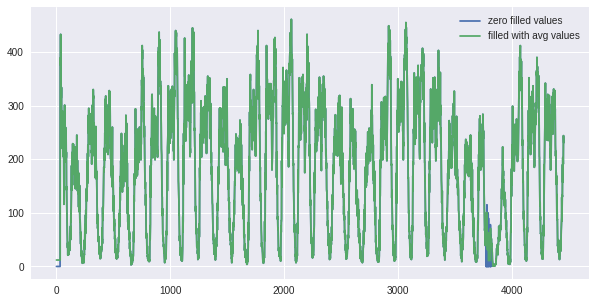

In [0]:
# Smoothing vs Filling
# sample plot that shows two variations of filling missing values
# we have taken the number of pickups for cluster region 2
plt.figure(figsize=(10,5))
plt.plot(jan_2015_fill[4464:8920], label="zero filled values")
plt.plot(jan_2015_smooth[4464:8920], label="filled with avg values")
plt.legend()
plt.show()

In [0]:
# Jan-2015 data is smoothed, Jan,Feb & March 2016 data missing values are filled with zero
jan_2015_smooth = smoothing(jan_2015_groupby['trip_distance'].values,jan_2015_unique)
jan_2016_smooth = fill_missing(jan_2016_groupby['trip_distance'].values,jan_2016_unique)
feb_2016_smooth = fill_missing(feb_2016_groupby['trip_distance'].values,feb_2016_unique)
mar_2016_smooth = fill_missing(mar_2016_groupby['trip_distance'].values,mar_2016_unique)

# Making list of all the values of pickup data in every bin for a period of 3 months and storing them region-wise 
regions_cum = []

# a =[1,2,3]
# b = [2,3,4]
# a+b = [1, 2, 3, 2, 3, 4]

# number of 10min indices for jan 2015= 24*31*60/10 = 4464
# number of 10min indices for jan 2016 = 24*31*60/10 = 4464
# number of 10min indices for feb 2016 = 24*29*60/10 = 4176
# number of 10min indices for march 2016 = 24*31*60/10 = 4464
# regions_cum: it will contain 40 lists, each list will contain 4464+4176+4464 values which represents the number of pickups 
# that are happened for three months in 2016 data

for i in range(0,30):
    regions_cum.append(jan_2016_smooth[4464*i:4464*(i+1)]+feb_2016_smooth[4176*i:4176*(i+1)]+mar_2016_smooth[4464*i:4464*(i+1)])


## Time series and Fourier Transforms

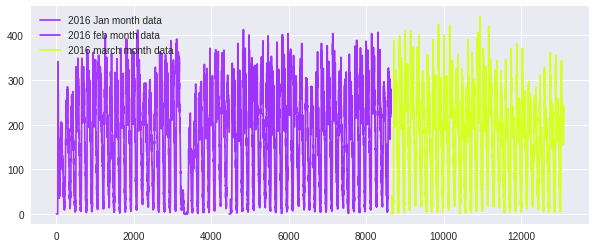

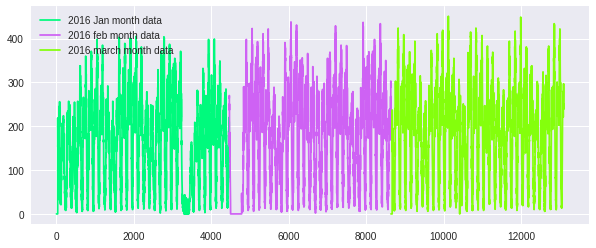

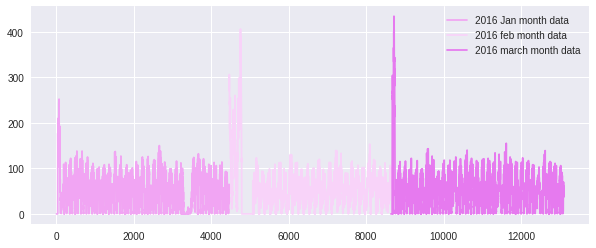

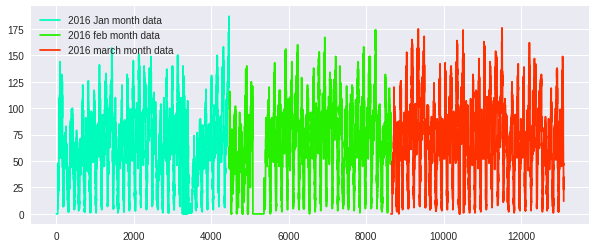

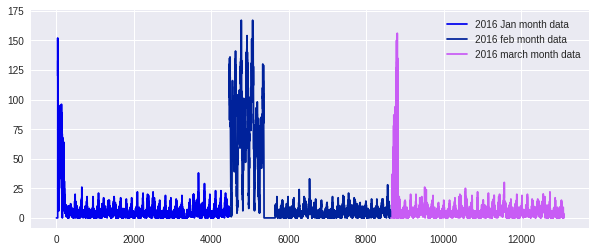

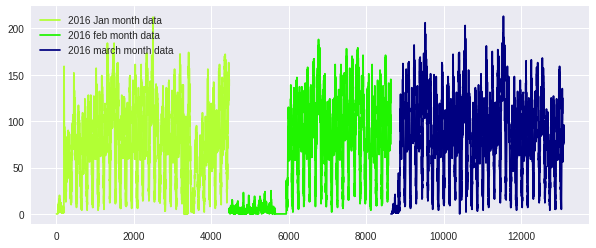

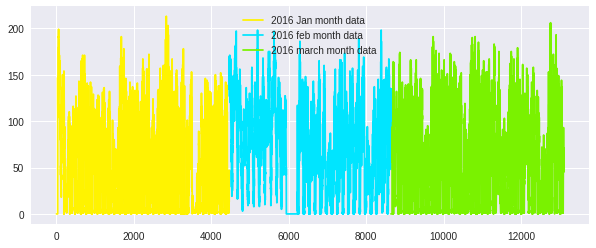

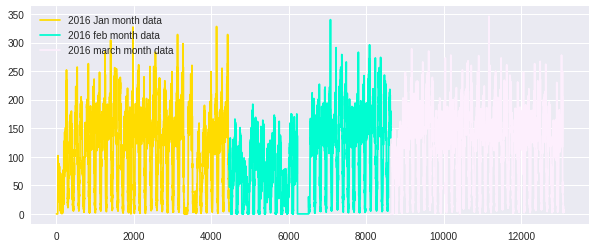

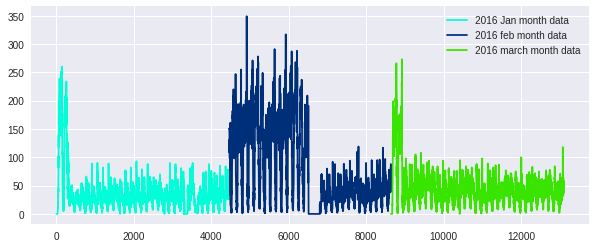

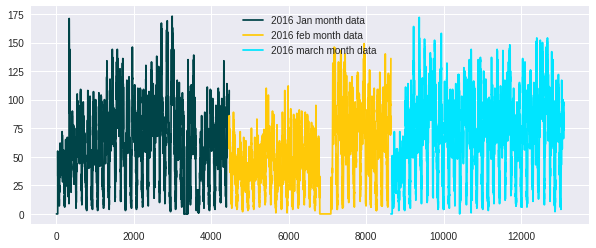

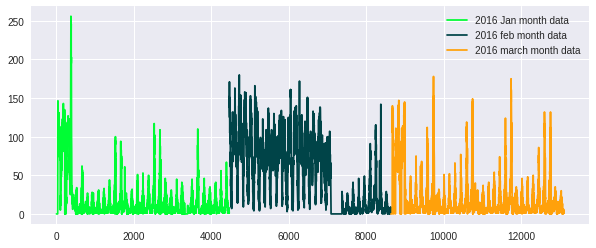

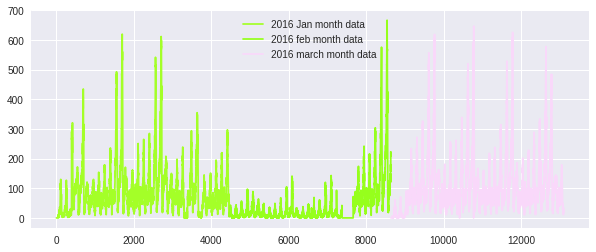

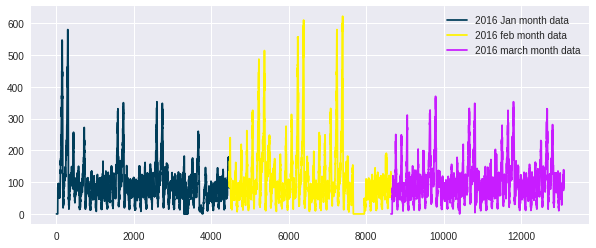

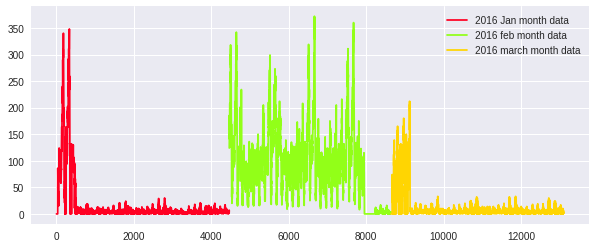

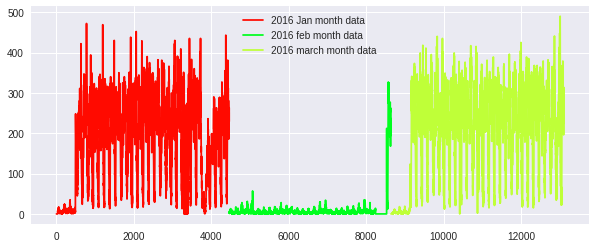

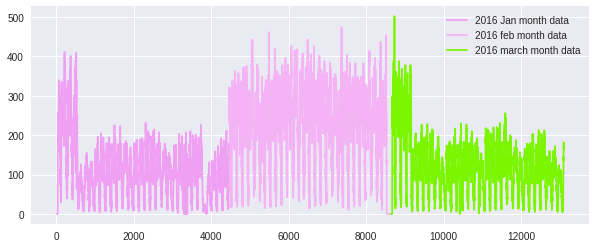

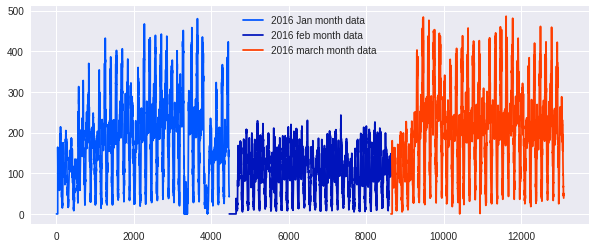

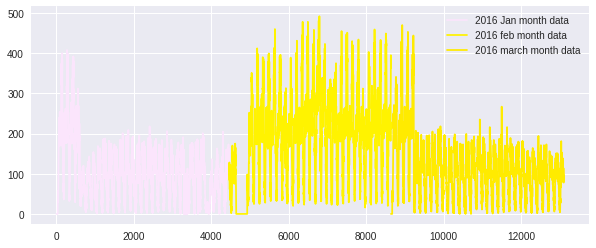

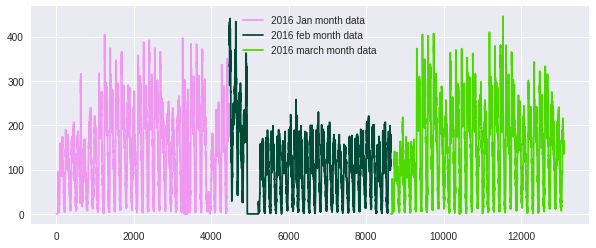

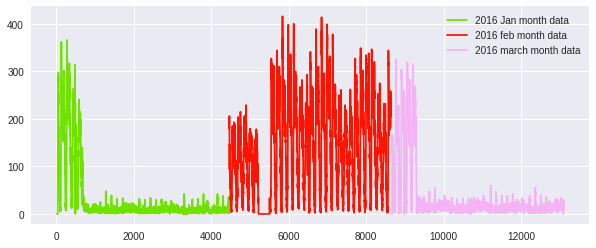

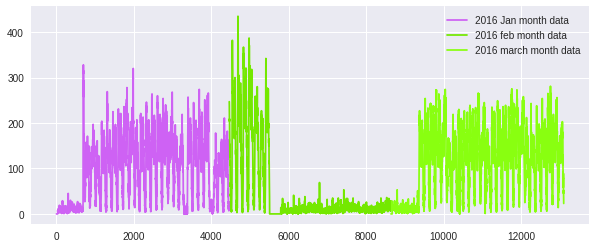

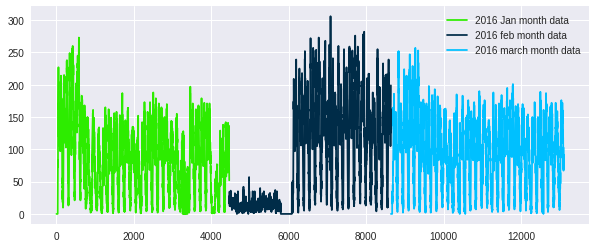

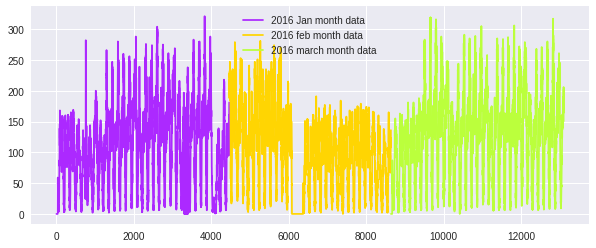

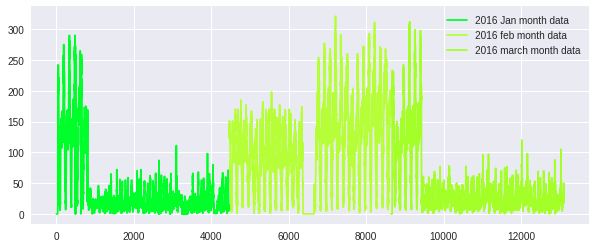

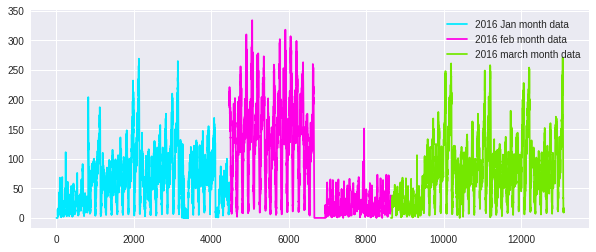

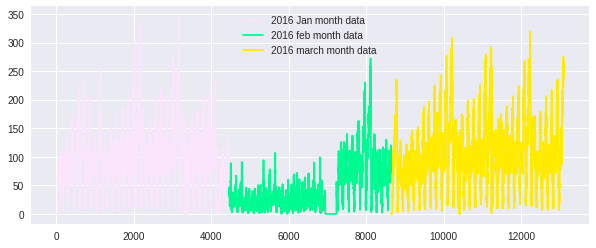

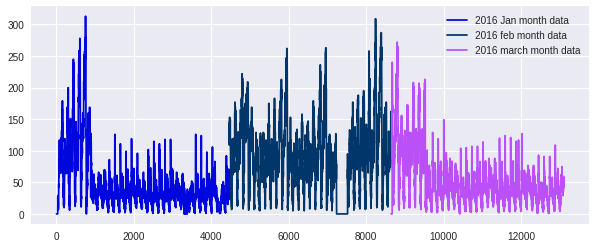

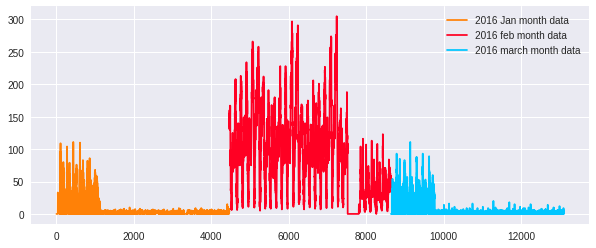

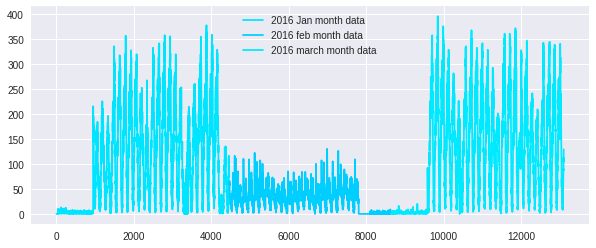

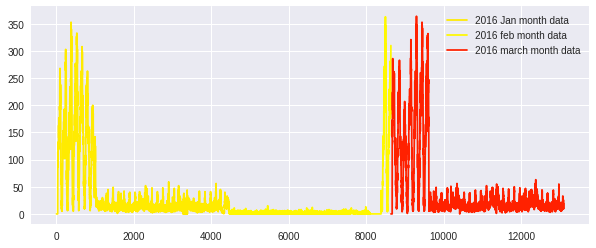

In [0]:
def uniqueish_color():
    """There're better ways to generate unique colors, but this isn't awful."""
    return plt.cm.gist_ncar(np.random.random())
first_x = list(range(0,4464))
second_x = list(range(4464,8640))
third_x = list(range(8640,13104))
for i in range(30):
    plt.figure(figsize=(10,4))
    plt.plot(first_x,regions_cum[i][:4464], color=uniqueish_color(), label='2016 Jan month data')
    plt.plot(second_x,regions_cum[i][4464:8640], color=uniqueish_color(), label='2016 feb month data')
    plt.plot(third_x,regions_cum[i][8640:], color=uniqueish_color(), label='2016 march month data')
    plt.legend()
    plt.show()

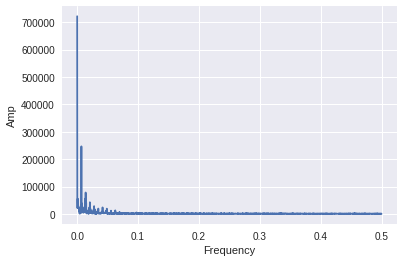

In [0]:
# getting peaks: https://blog.ytotech.com/2015/11/01/findpeaks-in-python/
# read more about fft function : https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fft.html
Y    = np.fft.fft(np.array(jan_2016_smooth)[0:4460])
# read more about the fftfreq: https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fftfreq.html  
freq = np.fft.fftfreq(4460, 1)
n = len(freq)
plt.figure()
plt.plot( freq[:int(n/2)], np.abs(Y)[:int(n/2)] )
plt.xlabel("Frequency")
plt.ylabel('Amp')
plt.show()

In [0]:
#Preparing the Dataframe only with x(i) values as jan-2015 data and y(i) values as jan-2016
ratios_jan = pd.DataFrame()
ratios_jan['Given']=jan_2015_smooth
ratios_jan['Prediction']=jan_2016_smooth
ratios_jan['Ratios']=ratios_jan['Prediction']*1.0/ratios_jan['Given']*1.0

In [0]:
ratios_jan.tail().style.highlight_max(axis=0)

,Given,Prediction,Ratios
133915,30,11,0.366667
133916,26,7,0.269231
133917,30,5,0.166667
133918,26,16,0.615385
133919,25,15,0.6


## Modelling: Baseline Models

Now we get into modelling in order to forecast the pickup densities for the months of Jan, Feb and March of 2016 for which we are using multiple models with two variations 
1. Using Ratios of the 2016 data to the 2015 data 
2. Using Previous known values of the 2016 data itself to predict the future values

### Simple Moving Averages
The First Model used is the Moving Averages Model which uses the previous n values in order to predict the next value 

In [0]:
def MA_R_Predictions(ratios,month):
    predicted_ratio=(ratios['Ratios'].values)[0]
    error=[]
    predicted_values=[]
    window_size=3
    predicted_ratio_values=[]
    for i in range(0,4464*30):
        if i%4464==0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(int(((ratios['Given'].values)[i])*predicted_ratio))
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*predicted_ratio)-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            predicted_ratio=sum((ratios['Ratios'].values)[(i+1)-window_size:(i+1)])/window_size
        else:
            predicted_ratio=sum((ratios['Ratios'].values)[0:(i+1)])/(i+1)
            
    
    ratios['MA_R_Predicted'] = predicted_values
    ratios['MA_R_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

In [0]:
def MA_P_Predictions(ratios,month):
    predicted_value=(ratios['Prediction'].values)[0]
    error=[]
    predicted_values=[]
    window_size=1
    predicted_ratio_values=[]
    for i in range(0,4464*30):
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            predicted_value=int(sum((ratios['Prediction'].values)[(i+1)-window_size:(i+1)])/window_size)
        else:
            predicted_value=int(sum((ratios['Prediction'].values)[0:(i+1)])/(i+1))
            
    ratios['MA_P_Predicted'] = predicted_values
    ratios['MA_P_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

### Weighted Moving Averages
The Moving Avergaes Model used gave equal importance to all the values in the window used, but we know intuitively that the future is more likely to be similar to the latest values and less similar to the older values. Weighted Averages converts this analogy into a mathematical relationship giving the highest weight while computing the averages to the latest previous value and decreasing weights to the subsequent older ones

In [0]:
def WA_R_Predictions(ratios,month):
    predicted_ratio=(ratios['Ratios'].values)[0]
    alpha=0.5
    error=[]
    predicted_values=[]
    window_size=5
    predicted_ratio_values=[]
    for i in range(0,4464*30):
        if i%4464==0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(int(((ratios['Given'].values)[i])*predicted_ratio))
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*predicted_ratio)-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            sum_values=0
            sum_of_coeff=0
            for j in range(window_size,0,-1):
                sum_values += j*(ratios['Ratios'].values)[i-window_size+j]
                sum_of_coeff+=j
            predicted_ratio=sum_values/sum_of_coeff
        else:
            sum_values=0
            sum_of_coeff=0
            for j in range(i+1,0,-1):
                sum_values += j*(ratios['Ratios'].values)[j-1]
                sum_of_coeff+=j
            predicted_ratio=sum_values/sum_of_coeff
            
    ratios['WA_R_Predicted'] = predicted_values
    ratios['WA_R_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

In [0]:
def WA_P_Predictions(ratios,month):
    predicted_value=(ratios['Prediction'].values)[0]
    error=[]
    predicted_values=[]
    window_size=2
    for i in range(0,4464*30):
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            sum_values=0
            sum_of_coeff=0
            for j in range(window_size,0,-1):
                sum_values += j*(ratios['Prediction'].values)[i-window_size+j]
                sum_of_coeff+=j
            predicted_value=int(sum_values/sum_of_coeff)

        else:
            sum_values=0
            sum_of_coeff=0
            for j in range(i+1,0,-1):
                sum_values += j*(ratios['Prediction'].values)[j-1]
                sum_of_coeff+=j
            predicted_value=int(sum_values/sum_of_coeff)
    
    ratios['WA_P_Predicted'] = predicted_values
    ratios['WA_P_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

For the above the Hyperparameter is the window-size (n) which is tuned manually and it is found that the window-size of 2 is optimal for getting the best results using Weighted Moving Averages using previous 2016 values 

### Exponential  Weighted Moving Averages



In [0]:
def EA_R1_Predictions(ratios,month):
    predicted_ratio=(ratios['Ratios'].values)[0]
    alpha=0.6
    error=[]
    predicted_values=[]
    predicted_ratio_values=[]
    for i in range(0,4464*30):
        if i%4464==0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(int(((ratios['Given'].values)[i])*predicted_ratio))
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*predicted_ratio)-(ratios['Prediction'].values)[i],1))))
        predicted_ratio = (alpha*predicted_ratio) + (1-alpha)*((ratios['Ratios'].values)[i])
    
    ratios['EA_R1_Predicted'] = predicted_values
    ratios['EA_R1_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

In [0]:
def EA_P1_Predictions(ratios,month):
    predicted_value= (ratios['Prediction'].values)[0]
    alpha=0.3
    error=[]
    predicted_values=[]
    for i in range(0,4464*30):
        if i%4464==0:
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['Prediction'].values)[i],1))))
        predicted_value =int((alpha*predicted_value) + (1-alpha)*((ratios['Prediction'].values)[i]))
    
    ratios['EA_P1_Predicted'] = predicted_values
    ratios['EA_P1_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

In [0]:

mean_err=[0]*6

median_err=[0]*6
ratios_jan,mean_err[0],median_err[0]=MA_R_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[1],median_err[1]=MA_P_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[2],median_err[2]=WA_R_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[3],median_err[3]=WA_P_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[4],median_err[4]=EA_R1_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[5],median_err[5]=EA_P1_Predictions(ratios_jan,'jan')

In [0]:
print(len(mean_err))
print(len(median_err))

6
6


## Comparison between baseline models
We have chosen our error metric for comparison between models as MAPE (Mean Absolute Percentage Error)  so that we can know that on an average how good is our model with predictions and MSE (Mean Squared Error)  is also used so that we have a clearer understanding as to how well our forecasting model performs with outliers so that we make sure that there is not much of a error margin between our prediction and the actual value

In [0]:
print ("Error Metric Matrix (Forecasting Methods) - MAPE & MSE")
print ("--------------------------------------------------------------------------------------------------------")
print ("Moving Averages (Ratios) -                             MAPE: ",mean_err[0],"      MSE: ",median_err[0])
print ("Moving Averages (2016 Values) -                        MAPE: ",mean_err[1],"       MSE: ",median_err[1])
print ("--------------------------------------------------------------------------------------------------------")
print ("Weighted Moving Averages (Ratios) -                    MAPE: ",mean_err[2],"      MSE: ",median_err[2])
print ("Weighted Moving Averages (2016 Values) -               MAPE: ",mean_err[3],"      MSE: ",median_err[3])
print ("--------------------------------------------------------------------------------------------------------")
print ("Exponential Moving Averages (Ratios) -              MAPE: ",mean_err[4],"      MSE: ",median_err[4])
print ("Exponential Moving Averages (2016 Values) -         MAPE: ",mean_err[5],"      MSE: ",median_err[5])
print ("--------------------------------------------------------------------------------------------------------")
#print ("ARIMA (Ratios) -              MAPE: ",mean_err[6],"      MSE: ",median_err[6])
#print ("ARIMA (2016 Values) -         MAPE: ",mean_err[7],"      MSE: ",median_err[7])

Error Metric Matrix (Forecasting Methods) - MAPE & MSE
--------------------------------------------------------------------------------------------------------
Moving Averages (Ratios) -                             MAPE:  0.2116166964874202       MSE:  7399.9824298088415
Moving Averages (2016 Values) -                        MAPE:  0.13485447972674997        MSE:  326.3647028076464
--------------------------------------------------------------------------------------------------------
Weighted Moving Averages (Ratios) -                    MAPE:  0.21269821218044424       MSE:  6559.883602150538
Weighted Moving Averages (2016 Values) -               MAPE:  0.1294325502895356       MSE:  296.25813918757467
--------------------------------------------------------------------------------------------------------
Exponential Moving Averages (Ratios) -              MAPE:  0.2122523879026215       MSE:  5155.116980286738
Exponential Moving Averages (2016 Values) -         MAPE:  0.129222667322

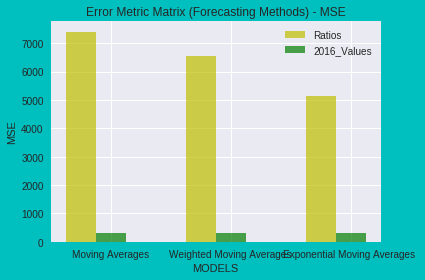

In [0]:

n_gro=3
Ratios=(median_err[0],median_err[2],median_err[4])
Values_2016=(median_err[1],median_err[3],median_err[5])
fig4 = plt.figure( facecolor='c', edgecolor='k')
index = np.arange(n_gro)
bar_width = 0.25
opacity = 0.7
 
result1 = plt.bar(index, Ratios, bar_width,
alpha=opacity,
color='y',
label='Ratios')
 
result2 = plt.bar(index + bar_width, Values_2016, bar_width,
alpha=opacity,
color='g',
label='2016_Values')
 
plt.xlabel('MODELS')
plt.ylabel('MSE')
plt.title('Error Metric Matrix (Forecasting Methods) - MSE')
plt.xticks(index + bar_width, ('Moving Averages', 'Weighted Moving Averages', 
                               'Exponential Moving Averages '))
plt.legend()
 
plt.tight_layout()
plt.show()

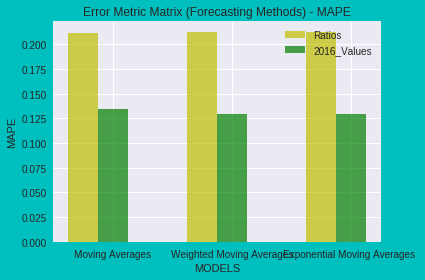

In [0]:

n_gro=3
Ratios=(mean_err[0],mean_err[2],mean_err[4])
Values_2016=(mean_err[1],mean_err[3],mean_err[5])
fig4 = plt.figure( facecolor='c', edgecolor='k')
index = np.arange(n_gro)
bar_width = 0.25
opacity = 0.7
 
result1 = plt.bar(index, Ratios, bar_width,
alpha=opacity,
color='y',
label='Ratios')
 
result2 = plt.bar(index + bar_width, Values_2016, bar_width,
alpha=opacity,
color='g',
label='2016_Values')
 
plt.xlabel('MODELS')
plt.ylabel('MAPE')
plt.title('Error Metric Matrix (Forecasting Methods) - MAPE')
plt.xticks(index + bar_width, ('Moving Averages', 'Weighted Moving Averages', 
                               'Exponential Moving Averages '))
plt.legend()
 
plt.tight_layout()
plt.show()

The histogram plot for Error Metric Matrix (Forecasting Methods) - MAPE & MSE is shown as above. From above histogram,It can be conclud that MAPE is best error metric as comapred to MSE metric.

Plese Note:- The above comparisons are made using Jan 2015 and Jan 2016 only

## Regression Models

### Train-Test Split
Before we start predictions using the tree based regression models we take 3 months of 2016 pickup data and split it such that for every region we have 75% data in train and 25% in test, ordered date-wise for every region

In [0]:
# Preparing data to be split into train and test, The below prepares data in cumulative form which will be later split into test and train
# number of 10min indices for jan 2015= 24*31*60/10 = 4464
# number of 10min indices for jan 2016 = 24*31*60/10 = 4464
# number of 10min indices for feb 2016 = 24*29*60/10 = 4176
# number of 10min indices for march 2016 = 24*31*60/10 = 4464
# regions_cum: it will contain 40 lists, each list will contain 4464+4176+4464 values 
#which represents the number of pickups 
# that are happened for three months in 2016 data

# print(len(regions_cum))
# 40
# print(len(regions_cum[0]))
# 12960

# we take number of pickups that are happened in last 5 10min intravels
number_of_time_stamps = 5

# output varaible
# it is list of lists
# it will contain number of pickups 13099 for each cluster
output = []


# tsne_lat will contain 13104-5=13099 times lattitude of cluster center for every cluster
# Ex: [[cent_lat 13099times],[cent_lat 13099times], [cent_lat 13099times].... 40 lists]
# it is list of lists
tsne_lat = []


# tsne_lon will contain 13104-5=13099 times logitude of cluster center for every cluster
# Ex: [[cent_long 13099times],[cent_long 13099times], [cent_long 13099times].... 40 lists]
# it is list of lists
tsne_lon = []

# we will code each day 
# sunday = 0, monday=1, tue = 2, wed=3, thur=4, fri=5,sat=6
# for every cluster we will be adding 13099 values, each value represent to which day of the week that pickup bin belongs to
# it is list of lists
tsne_weekday = []

# its an numbpy array, of shape (523960, 5)
# each row corresponds to an entry in out data
# for the first row we will have [f0,f1,f2,f3,f4] fi=number of pickups happened in i+1th 10min intravel(bin)
# the second row will have [f1,f2,f3,f4,f5]
# the third row will have [f2,f3,f4,f5,f6]
# and so on...
tsne_feature = []


tsne_feature = [0]*number_of_time_stamps
fram_final = pd.DataFrame(columns= ['f_1','a_1',
                                    'f_2','a_2',
                                    'f_3','a_3',
                                    'f_4','a_4',
                                    'f_5','a_5'])
for i in range(0,30):
  # amplitutude €& frequecy are calcualted &  saved in dataframe
  ampJan = np.fft.fft(np.array(regions_cum[i][0:4464]))
  freqJan = np.fft.fftfreq((4464), 1)
  ampFeb = list(np.fft.fft(np.array(regions_cum[i])[4464:(4176+4464)]))
  freqFeb = list(np.fft.fftfreq((4176), 1))
  #print('okay')
  ampMar = list(np.fft.fft(np.array(regions_cum[i])[(4176+4464):(4176+4464+4464)]))
  freqMar = list(np.fft.fftfreq((4464), 1))
  fram_jan = pd.DataFrame(data=freqJan,columns=['Freq'])
  fram_jan = pd.DataFrame(data=ampJan,columns=['Amp'])
  fram_feb =  pd.DataFrame(data=freqFeb,columns=['Freq'])
  fram_feb = pd.DataFrame(data=ampFeb,columns=['Amp'])
  fram_mar =  pd.DataFrame(data=freqMar,columns=['Freq'])
  fram_mar = pd.DataFrame(data=ampMar,columns=['Amp'])
 



  fram_list_jan = []
  fram_list_feb = []
  fram_list_mar = []

  fram_jan_sort = fram_jan.sort_values(by=['Amp'], ascending=False)[:5].reset_index(drop=True).T
  #print(fram_jan_sorted)
  fram_feb_sort = fram_feb.sort_values(by=['Amp'], ascending=False)[:5].reset_index(drop=True).T
  fram_mar_sort = fram_mar.sort_values(by=['Amp'], ascending=False)[:5].reset_index(drop=True).T
 # print(fram_mar_sort)
  #print(type(fram_jan_sort['Freq'][0]))
  for j in range(0,5):
    fram_list_jan.append(float(fram_jan_sort[j]))
    fram_list_jan.append(float(fram_jan_sort[j]))

    fram_list_feb.append(float(fram_feb_sort[j]))
    fram_list_feb.append(float(fram_feb_sort[j]))

    fram_list_mar.append(float(fram_mar_sort[j]))
    fram_list_mar.append(float(fram_mar_sort[j]))

  data1=[fram_list_jan]*4464
  data2=[fram_list_feb]*4176
  data3=[fram_list_mar]*4464
  col_name=['f_1','a_1','f_2','a_2','f_3','a_3','f_4','a_4','f_5','a_5']
  fram_new_jan = pd.DataFrame(data=data1,columns=col_name)
  fram_new_feb = pd.DataFrame(data=data2,columns=col_name)
  fram_new_mar = pd.DataFrame(data=data3,columns=col_name)

    
  fram_final = fram_final.append(fram_new_jan, ignore_index=True)
  fram_final = fram_final.append(fram_new_feb, ignore_index=True)
  fram_final = fram_final.append(fram_new_mar, ignore_index=True)    
  #print([kmeans.cluster_centers_[i][0]]*5)
  tsne_lat.append([kmeans.cluster_centers_[i][0]]*13099)
  tsne_lon.append([kmeans.cluster_centers_[i][1]]*13099)
  # jan 1st 2016 is thursday, so we start our day from 4: "(int(k/144))%7+4"
  # our prediction start from 5th 10min intravel since we need to have number of pickups that are happened in last 5 pickup bins
  tsne_weekday.append([int(((int(k/144))%7+4)%7) for k in range(5,4464+4176+4464)])
  # regions_cum is a list of lists [[x1,x2,x3..x13104], [x1,x2,x3..x13104], [x1,x2,x3..x13104], [x1,x2,x3..x13104], [x1,x2,x3..x13104], .. 40 lsits]
  tsne_feature = np.vstack((tsne_feature, [regions_cum[i][r:r+number_of_time_stamps] for r in range(0,len(regions_cum[i])-number_of_time_stamps)]))
  output.append(regions_cum[i][5:])
tsne_feature = tsne_feature[1:]
fram_final.drop(['f_1'],axis=1,inplace=True)

fram_final = fram_final
fram_final = fram_final.fillna(0)
 


##### Amplitude and frequency of  regions_cum are calculated  and saved in dataframe .These features are used for further time series analysis.


In [0]:
print(tsne_feature.shape)
print(fram_final.shape)

(392970, 5)
(393120, 9)


In [0]:
len(tsne_lat[0])*len(tsne_lat) == tsne_feature.shape[0] == len(tsne_weekday)*len(tsne_weekday[0]) == 30*13099 == len(output)*len(output[0])

True

In [0]:
alpha=0.3
predicted_values=[]
predict_list = []
tsne_flat_exp_avg = []

for r in range(0,30):    
    for i in range(0,13104):
        if i==0:
            predicted_value= regions_cum[r][0]
            predicted_values.append(0)
            continue
        predicted_values.append(predicted_value)
        predicted_value =int((alpha*predicted_value) + (1-alpha)*(regions_cum[r][i]))
    predict_list.append(predicted_values[5:])
    predicted_values=[]


In [0]:
print(fram_final.head(4))

        a_1            f_2            a_2            f_3            a_3  \
0  722880.0  122612.580586  122612.580586  122612.580586  122612.580586   
1  722880.0  122612.580586  122612.580586  122612.580586  122612.580586   
2  722880.0  122612.580586  122612.580586  122612.580586  122612.580586   
3  722880.0  122612.580586  122612.580586  122612.580586  122612.580586   

            f_4           a_4           f_5           a_5  
0  37871.050808  37871.050808  37871.050808  37871.050808  
1  37871.050808  37871.050808  37871.050808  37871.050808  
2  37871.050808  37871.050808  37871.050808  37871.050808  
3  37871.050808  37871.050808  37871.050808  37871.050808  


#### train, test split : 75% 25% split

In [0]:
# train, test split : 75% 25% split
# Before we star|||||t predictions using the tree based regression models we take 3 months of 2016 pickup data 
# and split it such that for every region we have 70% data in train and 30% in test,
# ordered date-wise for every region
print("size of train data :", int(13099*0.75))
print("size of test data :", int(13099*0.25))

size of train data : 9824
size of test data : 3274


In [0]:
# extracting first 9824 timestamp values i.e 75% of 13099 (total timestamps) for our training data
train_features =  [tsne_feature[i*13099:(13099*i+9824)] for i in range(0,30)]
# temp = [0]*(12955 - 9068)
test_features = [tsne_feature[(13099*(i))+9824:13099*(i+1)] for i in range(0,30)]

In [0]:
train_features =  [tsne_feature[i*13099:(13099*i+9824)] for i in range(0,30)]
test_features = [tsne_feature[(13099*(i))+9824:13099*(i+1)] for i in range(0,30)]
fram_final_train = pd.DataFrame(columns=['a_1','f_2','a_2','f_3','a_3',
                                         'f_4','a_4','f_5','a_5'])
fram_final_test = pd.DataFrame(columns=['a_1','f_2','a_2','f_3','a_3',
                                        'f_4','a_4','f_5','a_5'])
for i in range(0,30):
  #print(fram_final[i*13099:(13099*i+9824)])
  fram_final_train = fram_final_train.append(fram_final[i*13099:(13099*i+9824)] )
fram_final_train.reset_index(inplace=True)
for i in range(0,30):
  #print(fram_final[(13099*(i))+9824:13099*(i+1)])
  fram_final_test = fram_final_test.append(fram_final[(13099*(i))+9824:13099*(i+1)])
fram_final_test.reset_index(inplace=True)

In [0]:
fram_final_test.drop(['index'],axis=1,inplace=True)
fram_final_train.drop(['index'],axis=1,inplace=True)

In [0]:
print("Number of data clusters",len(train_features), "Number of data points in trian data", len(train_features[0]), "Each data point contains", len(train_features[0][0]),"features")
print("Number of data clusters",len(train_features), "Number of data points in test data", len(test_features[0]), "Each data point contains", len(test_features[0][0]),"features")

Number of data clusters 30 Number of data points in trian data 9824 Each data point contains 5 features
Number of data clusters 30 Number of data points in test data 3275 Each data point contains 5 features


In [0]:
# extracting first 9824 timestamp values i.e 75% of 13099 (total timestamps) for our training data
tsne_train_flat_lat = [i[:9824] for i in tsne_lat]
tsne_train_flat_lon = [i[:9824] for i in tsne_lon]
tsne_train_flat_weekday = [i[:9824] for i in tsne_weekday]
tsne_train_flat_output = [i[:9824] for i in output]
tsne_train_flat_exp_avg = [i[:9824] for i in predict_list]


In [0]:
# extracting the rest of the timestamp values i.e 25% of 12956 (total timestamps) for our test data
tsne_test_flat_lat = [i[9824:] for i in tsne_lat]
tsne_test_flat_lon = [i[9824:] for i in tsne_lon]
tsne_test_flat_weekday = [i[9824:] for i in tsne_weekday]
tsne_test_flat_output = [i[9824:] for i in output]
tsne_test_flat_exp_avg = [i[9824:] for i in predict_list]

In [0]:
# the above contains values in the form of list of lists 
#(i.e. list of values of each region), here we make all of them in one list
train_new_features = []
for i in range(0,30):
    train_new_features.extend(train_features[i])
test_new_features = []
for i in range(0,30):
    test_new_features.extend(test_features[i])

In [0]:
# converting lists of lists into sinle list i.e flatten
# a  = [[1,2,3,4],[4,6,7,8]]
# print(sum(a,[]))
# [1, 2, 3, 4, 4, 6, 7, 8]

tsne_train_lat = sum(tsne_train_flat_lat, [])
tsne_train_lon = sum(tsne_train_flat_lon, [])
tsne_train_weekday = sum(tsne_train_flat_weekday, [])
tsne_train_output = sum(tsne_train_flat_output, [])
tsne_train_exp_avg = sum(tsne_train_flat_exp_avg,[])

In [0]:
# converting lists of lists into sinle list i.e flatten
# a  = [[1,2,3,4],[4,6,7,8]]
# print(sum(a,[]))
# [1, 2, 3, 4, 4, 6, 7, 8]

tsne_test_lat = sum(tsne_test_flat_lat, [])
tsne_test_lon = sum(tsne_test_flat_lon, [])
tsne_test_weekday = sum(tsne_test_flat_weekday, [])
tsne_test_output = sum(tsne_test_flat_output, [])
tsne_test_exp_avg = sum(tsne_test_flat_exp_avg,[])

In [0]:
# Preparing the data frame for our train data
columns = ['ft_5','ft_4','ft_3','ft_2','ft_1']
df_train = pd.DataFrame(data=train_new_features, columns=columns) 
df_train['lat'] = tsne_train_lat
df_train['lon'] = tsne_train_lon
df_train['weekday'] = tsne_train_weekday
df_train['exp_avg'] = tsne_train_exp_avg

print(df_train.shape)

(294720, 9)


In [0]:
# Preparing the data frame for our train data
df_test = pd.DataFrame(data=test_new_features, columns=columns) 
df_test['lat'] = tsne_test_lat
df_test['lon'] = tsne_test_lon
df_test['weekday'] = tsne_test_weekday
df_test['exp_avg'] = tsne_test_exp_avg
print(df_test.shape)

(98250, 9)


In [0]:
df_test.head()

,ft_5,ft_4,ft_3,ft_2,ft_1,lat,lon,weekday,exp_avg
0,40,46,35,42,20,40.777809,-73.954054,2,26
1,46,35,42,20,32,40.777809,-73.954054,2,30
2,35,42,20,32,18,40.777809,-73.954054,2,21
3,42,20,32,18,21,40.777809,-73.954054,2,21
4,20,32,18,21,23,40.777809,-73.954054,2,22


In [0]:
df_test_lm = pd.concat([df_test, fram_final_test], axis=1)
df_train_lm = pd.concat([df_train, fram_final_train], axis=1)
#df_train_lm=df_train_lm.isnull().fillna(0)
df_test_lm.head()
print(df_test_lm.columns)
print(df_train_lm.columns)

Index(['ft_5', 'ft_4', 'ft_3', 'ft_2', 'ft_1', 'lat', 'lon', 'weekday',
       'exp_avg', 'a_1', 'f_2', 'a_2', 'f_3', 'a_3', 'f_4', 'a_4', 'f_5',
       'a_5'],
      dtype='object')
Index(['ft_5', 'ft_4', 'ft_3', 'ft_2', 'ft_1', 'lat', 'lon', 'weekday',
       'exp_avg', 'a_1', 'f_2', 'a_2', 'f_3', 'a_3', 'f_4', 'a_4', 'f_5',
       'a_5'],
      dtype='object')


In [0]:
nan_rows = df_train_lm[df_train_lm.isnull().T.any().T]
print(nan_rows)

Empty DataFrame
Columns: [ft_5, ft_4, ft_3, ft_2, ft_1, lat, lon, weekday, exp_avg, a_1, f_2, a_2, f_3, a_3, f_4, a_4, f_5, a_5]
Index: []


In [0]:
print(df_train_lm.tail(3))

        ft_5  ft_4  ft_3  ft_2  ft_1        lat        lon  weekday  exp_avg  \
294717    17    15    15    11    16  40.756845 -73.926853        2       14   
294718    15    15    11    16    11  40.756845 -73.926853        2       11   
294719    15    11    16    11    12  40.756845 -73.926853        2       11   

             a_1           f_2           a_2           f_3           a_3  \
294717  197370.0  78422.972705  78422.972705  78422.972705  78422.972705   
294718  197370.0  78422.972705  78422.972705  78422.972705  78422.972705   
294719  197370.0  78422.972705  78422.972705  78422.972705  78422.972705   

                 f_4           a_4           f_5           a_5  
294717  27272.510077  27272.510077  27272.510077  27272.510077  
294718  27272.510077  27272.510077  27272.510077  27272.510077  
294719  27272.510077  27272.510077  27272.510077  27272.510077  


### Using Linear Regression


Here,df_train_lm & df_test_lm dataframe is used

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection  import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import RandomizedSearchCV

In [0]:
std_train=StandardScaler().fit_transform(df_train_lm)
std_test=StandardScaler().fit_transform(df_test_lm)
# parameter tuning
classifier_Lr= SGDRegressor(loss='squared_loss',penalty='l2')
lambda_val=[10**-14, 10**-12, 10**-10, 10**-8, 10**-6,
          10**-4, 10**-2, 10**0, 10**2, 10**4, 10**6]
HP={'alpha':lambda_val}
# 3fold cross-validation
grid_param=GridSearchCV(classifier_Lr,HP,
                       scoring='neg_mean_absolute_error',cv=3)
grid_param.fit(std_train,tsne_train_output)
best_alpha=grid_param.best_params_['alpha']
print('best_alpha==',best_alpha)

best_alpha== 1e-14


In [0]:

print(grid_param.best_estimator_)
print(grid_param.best_params_)

SGDRegressor(alpha=1e-14, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.01, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=None,
       n_iter=None, n_iter_no_change=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, tol=None, validation_fraction=0.1,
       verbose=0, warm_start=False)
{'alpha': 1e-14}


In [0]:
#applying linear regress ion with best hyper-parameter
clf = SGDRegressor(loss = "squared_loss", penalty = "l2", alpha = best_alpha)
clf.fit(std_train, tsne_train_output)


SGDRegressor(alpha=1e-14, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.01, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=None,
       n_iter=None, n_iter_no_change=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, tol=None, validation_fraction=0.1,
       verbose=0, warm_start=False)

In [0]:
y_pred = clf.predict(std_test)
lr_test_predictions = [round(value) for value in y_pred]
y_pred = clf.predict(std_train)
lr_train_predictions = [round(value) for value in y_pred]

In [0]:
df_train=df_train_lm
df_test=df_test_lm
#print(df_train.tail(3))

### Using Random Forest Regressor

In [0]:
#Hyper parameter tuning
C=[10,20,40]
random_clf=RandomForestRegressor(n_jobs=-1)
HP1={'n_estimators':C}
n_iter1=10
# 3fold cross-validation
grid_param1=RandomizedSearchCV(random_clf,HP1,
                       scoring='neg_mean_absolute_error',cv=3,
                               n_iter=n_iter1)
grid_param1.fit(df_train,tsne_train_output)
best_alpha1=grid_param1.best_params_['n_estimators']
print('best_alpha==',best_alpha1)

best_alpha== 40


In [0]:
clf1 = RandomForestRegressor(max_features='sqrt',min_samples_leaf=4,min_samples_split=3,n_estimators = best_alpha1, n_jobs = -1)
clf1.fit(df_train, tsne_train_output)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=4, min_samples_split=3,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [0]:
y_pred = clf1.predict(df_test)
rndf_test_predictions = [round(value) for value in y_pred]
y_pred = clf1.predict(df_train)
rndf_train_predictions = [round(value) for value in y_pred]

In [0]:
#feature importances based on analysis using random forest
print (df_train.columns)
print (clf1.feature_importances_)

Index(['ft_5', 'ft_4', 'ft_3', 'ft_2', 'ft_1', 'lat', 'lon', 'weekday',
       'exp_avg', 'a_1', 'f_2', 'a_2', 'f_3', 'a_3', 'f_4', 'a_4', 'f_5',
       'a_5'],
      dtype='object')
[0.03062103 0.11044806 0.12913676 0.15139442 0.30576413 0.00089343
 0.00073066 0.00112654 0.23073347 0.00351557 0.00786687 0.01020166
 0.0085716  0.00570907 0.00085969 0.0008553  0.00076875 0.000803  ]


### Using XgBoost Regressor

In [0]:
start=datetime.datetime.now()
HP2= {"max_depth": [3, 4,5],
              "min_child_weight": [3, 4,5,6],
              "gamma":[0,0.1,0.2],
              "colsample_bytree":[0.7,0.8,0.9],
              "nthread":[3,4,5]
              }
clf111 = xgb.XGBRegressor()
n_iter2 = 10
random_clf = RandomizedSearchCV(clf111, param_distributions=HP2,
                                   n_iter=n_iter2)

random_clf.fit(df_train, tsne_train_output)



RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'max_depth': [3, 4, 5], 'min_child_weight': [3, 4, 5, 6], 'gamma': [0, 0.1, 0.2], 'colsample_bytree': [0.7, 0.8, 0.9], 'nthread': [3, 4, 5]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [0]:
best_gamma=random_clf.best_params_['gamma']
print('best_gamma==',best_gamma)

best_gamma== 0.1


In [0]:
best_max_depth=random_clf.best_params_['max_depth']
print('best_max_depth==',best_max_depth)

best_min_child_weight  = random_clf.best_params_['min_child_weight']
print('best_min_child_weight==',best_min_child_weight)

best_colsample_bytree=random_clf.best_params_['colsample_bytree']
print('best_colsample_bytree==',best_colsample_bytree)
best_nthread=random_clf.best_params_['nthread']
print('best_nthread==',best_nthread)

best_max_depth== 4
best_min_child_weight== 3
best_colsample_bytree== 0.8
best_nthread== 4


In [0]:
clf2=xgb.XGBRegressor( learning_rate =0.1,
                      n_estimators=1000,
max_depth=best_max_depth,
                      min_child_weight=best_min_child_weight,
                      gamma=best_gamma,
                      subsample=0.8,
 reg_alpha=200, reg_lambda=200,
                      colsample_bytree=best_colsample_bytree,
                      nthread=best_nthread
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
                      
)


clf2.fit(df_train, tsne_train_output)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.1, learning_rate=0.1,
       max_delta_step=0, max_depth=4, min_child_weight=3, missing=None,
       n_estimators=1000, n_jobs=1, nthread=4, objective='reg:linear',
       random_state=0, reg_alpha=200, reg_lambda=200, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.8)

In [0]:
y_pred = clf2.predict(df_test)
xgb_test_predictions = [round(value) for value in y_pred]
y_pred = clf2.predict(df_train)
xgb_train_predictions = [round(value) for value in y_pred]

In [0]:
#feature importances
#clf2.booster().get_score(importance_type='weight')

### Calculating the error metric values for various models

In [0]:
train_mape=[]
test_mape=[]

train_mape.append((mean_absolute_error(tsne_train_output,
                                       df_train['ft_5'].values))/(sum(tsne_train_output)/len(tsne_train_output)))
train_mape.append((mean_absolute_error(tsne_train_output,df_train['exp_avg'].values))/(sum(tsne_train_output)/len(tsne_train_output)))
train_mape.append((mean_absolute_error(tsne_train_output,rndf_train_predictions))/(sum(tsne_train_output)/len(tsne_train_output)))
train_mape.append((mean_absolute_error(tsne_train_output, xgb_train_predictions))/(sum(tsne_train_output)/len(tsne_train_output)))
train_mape.append((mean_absolute_error(tsne_train_output, lr_train_predictions))/(sum(tsne_train_output)/len(tsne_train_output)))

test_mape.append((mean_absolute_error(tsne_test_output, df_test['ft_5'].values))/(sum(tsne_test_output)/len(tsne_test_output)))
test_mape.append((mean_absolute_error(tsne_test_output, df_test['exp_avg'].values))/(sum(tsne_test_output)/len(tsne_test_output)))
test_mape.append((mean_absolute_error(tsne_test_output, rndf_test_predictions))/(sum(tsne_test_output)/len(tsne_test_output)))
test_mape.append((mean_absolute_error(tsne_test_output, xgb_test_predictions))/(sum(tsne_test_output)/len(tsne_test_output)))
test_mape.append((mean_absolute_error(tsne_test_output, lr_test_predictions))/(sum(tsne_test_output)/len(tsne_test_output)))

# LSTM

In [0]:
# reference link
# https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
# https://machinelearningmastery.com/diagnose-overfitting-underfitting-lstm-models/
# https://machinelearningmastery.com/custom-metrics-deep-learning-keras-python/
import numpy 
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [0]:
# fix random seed for reproducibility
numpy.random.seed(7)

In [0]:
# Training datasets
se=pd.Series(tsne_train_output)
df_train['Y']=se.values
se1=pd.Series(tsne_test_output)
df_test['Y']=se1.values
print(df_train.tail())

        ft_5  ft_4  ft_3  ft_2  ft_1        lat        lon  weekday  exp_avg  \
294715    26    26    17    15    15  40.756845 -73.926853        2       15   
294716    26    17    15    15    11  40.756845 -73.926853        2       12   
294717    17    15    15    11    16  40.756845 -73.926853        2       14   
294718    15    15    11    16    11  40.756845 -73.926853        2       11   
294719    15    11    16    11    12  40.756845 -73.926853        2       11   

             a_1           f_2           a_2           f_3           a_3  \
294715  197370.0  78422.972705  78422.972705  78422.972705  78422.972705   
294716  197370.0  78422.972705  78422.972705  78422.972705  78422.972705   
294717  197370.0  78422.972705  78422.972705  78422.972705  78422.972705   
294718  197370.0  78422.972705  78422.972705  78422.972705  78422.972705   
294719  197370.0  78422.972705  78422.972705  78422.972705  78422.972705   

                 f_4           a_4           f_5           a_5

In [0]:
df_test.tail()

,ft_5,ft_4,ft_3,ft_2,ft_1,lat,lon,weekday,exp_avg,a_1,f_2,a_2,f_3,a_3,f_4,a_4,f_5,a_5,Y
98245,14,11,14,9,13,40.756845,-73.926853,3,12,197370.0,78422.972705,78422.972705,78422.972705,78422.972705,27272.510077,27272.510077,27272.510077,27272.510077,21
98246,11,14,9,13,21,40.756845,-73.926853,3,18,197370.0,78422.972705,78422.972705,78422.972705,78422.972705,27272.510077,27272.510077,27272.510077,27272.510077,18
98247,14,9,13,21,18,40.756845,-73.926853,3,18,197370.0,78422.972705,78422.972705,78422.972705,78422.972705,27272.510077,27272.510077,27272.510077,27272.510077,20
98248,9,13,21,18,20,40.756845,-73.926853,3,19,197370.0,78422.972705,78422.972705,78422.972705,78422.972705,27272.510077,27272.510077,27272.510077,27272.510077,22
98249,13,21,18,20,22,40.756845,-73.926853,3,21,197370.0,78422.972705,78422.972705,78422.972705,78422.972705,27272.510077,27272.510077,27272.510077,27272.510077,25


In [0]:
# Normalize
scaler=MinMaxScaler(feature_range=(0, 1))
df_train = scaler.fit_transform(df_train)
#print(df_train[:1])
#print(tsne_train_output)
df_test=scaler.fit_transform(df_test)

In [0]:
print(len(df_train))

294720


In [0]:
#tsne_train_output=np.asarray(tsne_train_output).reshape(-1, 1)
#tsne_train_output=scaler.fit_transform(tsne_train_output)

In [0]:
#print(tsne_train_output[:-10])

In [0]:
# reference https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
# create_dataset code is taken from above link
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)
# fix random seed for reproducibility
numpy.random.seed(7)

In [0]:
train_size=len(df_train)
test_size=len(df_test)
print(train_size)

294720


In [0]:
# 80% of df_train=235776 for training purpose
# 20 % of df_train=58944for validation purpose
training_data=df_train[:235776]
print(len(training_data))
val_data=df_train[235776:]
print(len(val_data))
#print(df_train[:5])

235776
58944


In [0]:
# reshape into X=t and Y=t+1
look_back = 18
trainX, trainY = create_dataset(training_data, look_back)
valX,valY= create_dataset(val_data,look_back)
testX, testY = create_dataset(df_test, look_back)

In [0]:
print(trainX.shape[1])

18


In [0]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
valX=numpy.reshape(valX,(valX.shape[0],1,valX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [0]:
import keras
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
keras.backend.set_epsilon(1)
model.compile(loss='mse', optimizer='adam', metrics=['mae','mape'])
historyy=model.fit(trainX, trainY, epochs=50, batch_size=100, verbose=2,
         validation_data=(valX,valY))
# make predictions

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 235757 samples, validate on 58925 samples
Epoch 1/50
 - 6s - loss: 0.0134 - mean_absolute_error: 0.0845 - mean_absolute_percentage_error: 8.4463 - val_loss: 0.0065 - val_mean_absolute_error: 0.0702 - val_mean_absolute_percentage_error: 7.0170
Epoch 2/50
 - 5s - loss: 0.0090 - mean_absolute_error: 0.0753 - mean_absolute_percentage_error: 7.5304 - val_loss: 0.0054 - val_mean_absolute_error: 0.0640 - val_mean_absolute_percentage_error: 6.3977
Epoch 3/50
 - 5s - loss: 0.0075 - mean_absolute_error: 0.0684 - mean_absolute_percentage_error: 6.8429 - val_loss: 0.0044 - val_mean_absolute_error: 0.0579 - val_mean_absolute_percentage_error: 5.7864
Epoch 4/50
 - 5s - loss: 0.0064 - mean_absolute_error: 0.0626 - mean_absolute_percentage_error: 6.2611 - val_loss: 0.0037 - val_mean_absolute_error: 0.0527 - val_mean_absolute_percentage_error: 5.2712
Epoch 5/50
 - 5s - loss: 

In [0]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [0]:
 print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 4)                 368       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 373
Trainable params: 373
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time
# https://gist.github.com/greydanus/f6eee59eaf1d90fcb3b534a25362cea4
# https://stackoverflow.com/a/14434334
# this function is used to update the plots for each epoch and error
def plt_dynamic(x, vy, ty):
  fig = plt.figure( facecolor='c', edgecolor='k')
  plt.plot(x, vy, 'b', label="Validation Loss")
  plt.plot(x, ty, 'r', label="Train Loss")
  plt.xlabel('Epochs') 
  plt.ylabel('loss')
  plt.legend()
  plt.grid()
  plt.show()

In [0]:
score=model.evaluate(testX, testY)
print(score)

98231/98231 [==============================] - 2s 21us/step
[0.0018505496639770593, 0.028194608164320362, 2.819460820585486]


test score : 0.0018505496639770593
test Accuracy mape : 2.819460820585486
test Accuracy mae : 0.028194608164320362
train accuracy mape: 2.8642178656231643
train accuracy mae: 0.028642178619559755


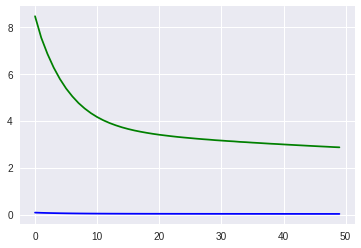

In [0]:

test_score=score[0]
test_accuracy_mae=score[1]
test_accuracy_mape=score[2]
train_accuracy_mape=min(historyy.history['mean_absolute_percentage_error'])
train_accuracy_mae=min(historyy.history['mean_absolute_error'])
print('test score :',test_score)
print('test Accuracy mape :',test_accuracy_mape)
print('test Accuracy mae :',test_accuracy_mae)
print('train accuracy mape:',train_accuracy_mape)
print('train accuracy mae:',train_accuracy_mae)
plt.plot(historyy.history['mean_absolute_error'],'b', label='mean_absolute_error')
plt.plot(historyy.history['mean_absolute_percentage_error'],'g', label='mean_absolute_percentage_error')
plt.show()


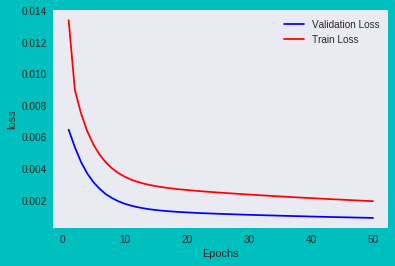

In [0]:
# error plot
x=list(range(1,51))
vy=historyy.history['val_loss'] #validation loss
ty=historyy.history['loss'] # train loss
plt_dynamic(x, vy, ty)

LSTM Model for Taxi predictions is underfitting.

In [0]:
print ("Error Metric Matrix (Tree Based Regression Methods) -  MAPE")
print ("--------------------------------------------------------------------------------------------------------")
print ("Baseline Model -                             Train: ",train_mape[0],"      Test: ",test_mape[0])
print ("Exponential Averages Forecasting -           Train: ",train_mape[1],"      Test: ",test_mape[1])
print ("Linear Regression -                         Train: ",train_mape[3],"      Test: ",test_mape[3])
print ("Random Forest Regression -                   Train: ",train_mape[2],"     Test: ",test_mape[2])

Error Metric Matrix (Tree Based Regression Methods) -  MAPE
--------------------------------------------------------------------------------------------------------
Baseline Model -                             Train:  0.22237704939723804       Test:  0.21305064353591457
Exponential Averages Forecasting -           Train:  0.12447032566743102       Test:  0.11957070580924961
Linear Regression -                         Train:  0.1194834480285695       Test:  0.11667201228838428
Random Forest Regression -                   Train:  0.08788070394339026      Test:  0.11694715964897352


### Error Metric Matrix

In [0]:
print ("Error Metric Matrix (Tree Based Regression Methods) -  MAPE")
print ("--------------------------------------------------------------------------------------------------------")
print ("Baseline Model -                             Train: ",train_mape[0],"      Test: ",test_mape[0])
print ("Exponential Averages Forecasting -           Train: ",train_mape[1],"      Test: ",test_mape[1])
print ("Linear Regression -                         Train: ",train_mape[4],"      Test: ",test_mape[4])
print ("Random Forest Regression -                   Train: ",train_mape[2],"     Test: ",test_mape[2])
print ("XgBoost Regression -                         Train: ",train_mape[3],"      Test: ",test_mape[3])
print ("LSTM -                                 Train: ",train_accuracy_mae,"    Test: ",test_accuracy_mae)
print ("--------------------------------------------------------------------------------------------------------")

Error Metric Matrix (Tree Based Regression Methods) -  MAPE
--------------------------------------------------------------------------------------------------------
Baseline Model -                             Train:  0.22237704939723804       Test:  0.21305064353591457
Exponential Averages Forecasting -           Train:  0.12447032566743102       Test:  0.11957070580924961
Linear Regression -                         Train:  0.12560219960808233       Test:  0.1362527203243064
Random Forest Regression -                   Train:  0.08788070394339026      Test:  0.11694715964897352
XgBoost Regression -                         Train:  0.1194834480285695       Test:  0.11667201228838428
LSTM -                                 Train:  0.028642178619559755     Test:  0.028194608164320362
--------------------------------------------------------------------------------------------------------


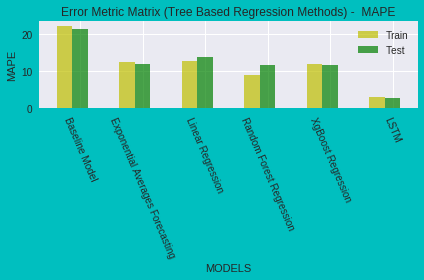

In [0]:

n_gro=6
train_mape=(train_mape[0]*100,train_mape[1]*100,train_mape[4]*100,
            train_mape[2]*100,train_mape[3]*100,train_accuracy_mae*100)
test_mape=(test_mape[0]*100,test_mape[1]*100,test_mape[4]*100,
          test_mape[2]*100,test_mape[3]*100,test_accuracy_mae*100)
fig4 = plt.figure( facecolor='c', edgecolor='k')
index = np.arange(n_gro)
bar_width = 0.25
opacity = 0.7
 
result1 = plt.bar(index, train_mape, bar_width,
alpha=opacity,
color='y',
label='Train')
 
result2 = plt.bar(index + bar_width, test_mape, bar_width,
alpha=opacity,
color='g',
label='Test')
 
plt.xlabel('MODELS')
plt.ylabel('MAPE')
plt.title('Error Metric Matrix (Tree Based Regression Methods) -  MAPE')
plt.xticks(index + bar_width, ('Baseline Model', 'Exponential Averages Forecasting', 
                               'Linear Regression ',
                 
                               'Random Forest Regression',
                              'XgBoost Regression',
                              'LSTM'),rotation=-67)
plt.legend()
 
plt.tight_layout()
plt.show()

# Final OBservation

## XgBoost Regression is best model among all .TEST MAPE=11.66%  and Train MAPE=11.94%

here, Random Forest Regression model  overfits as the difference between test and train error is too high

## NOTE:
 * If cluster size=40, the same code will results MAPE value>12%
 * LSTM undergoes underfitting.(here,This model does not work well )